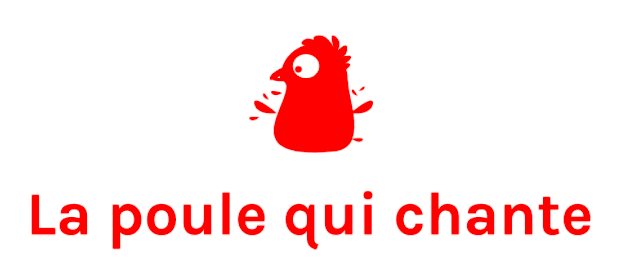

## Import des librairies

In [1]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns

In [2]:

# les fonctions sont issues du cours https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees

In [3]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(20,20))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()
    
def decompress_image(pca, std_scaler, compressed_img):
    img = pca.inverse_transform(compressed_img)
    img = std_scaler.inverse_transform(img)
    return img


## I. Préparation des données
### 1.1 Fichier disponibilité alimentaire pour les années 2017 2019
Note :

Afin de calculer de nouvelles variables représentant des taux d'évolution entre 2017 et 2019, des données supplémentaires ont été recherchées sur le site de la FAO.

Le site permettant de réaliser un export de données personnalisé (choix des pays années, des produits, des éléments à exporter...), un export unique visant à sélectionner, pour l'ensemble des pays :

les années souhaitées (2017 et 2019),
les éléments étudiés (disponibilité intérieure, import, export, production, disponibilité par personne et par jour)
les produits étudiés (éléments relatifs à la consommation de viande et à la population de chaque pays)
a été réalisé, ce qui a permis de réduire le volume de données importées dans le notebook initialement (176000 à 2421), le nombre de dataframes et fusions à réaliser.

L'export a été réalisé en anglais et non en français afin de régler le problème d'encodage des accents.

L'étude est donc réalisée à partir du Dataframe food_balances_2017_2019 directement et non le CSV DisponibilitéAlimentaire_2017 fourni par OpenClassrooms

### A - Présentation du fichier : variables, dimension, valeurs nulles, doublons

In [4]:
dispo_alimentaire = pd.read_csv("food_balances_17_2019.csv")
dispo_alimentaire.head()

,Domain,Area,Element,Item,Year,Unit,Value
0,Food Balances (2010-),Afghanistan,Total Population - Both sexes,Population,2017,1000 persons,36296.0
1,Food Balances (2010-),Afghanistan,Total Population - Both sexes,Population,2019,1000 persons,38042.0
2,Food Balances (2010-),Afghanistan,Domestic supply quantity,Population,2017,1000 tonnes,0.0
3,Food Balances (2010-),Afghanistan,Domestic supply quantity,Population,2019,1000 tonnes,0.0
4,Food Balances (2010-),Afghanistan,Production,Poultry Meat,2017,1000 tonnes,28.0


In [5]:
dispo_alimentaire.shape


(2419, 7)

In [6]:
dispo_alimentaire.dtypes


Domain      object
Area        object
Element     object
Item        object
Year         int64
Unit        object
Value      float64
dtype: object

In [7]:
dispo_alimentaire.describe(include = 'all')

,Domain,Area,Element,Item,Year,Unit,Value
count,2419,2419,2419,2419,2419.000000,2419,2.419000e+03
unique,1,179,6,2,NaN,3,NaN
top,Food Balances (2010-),Kuwait,Domestic supply quantity,Poultry Meat,NaN,1000 tonnes,NaN
freq,2419,14,716,1703,NaN,1703,NaN
mean,NaN,NaN,NaN,NaN,2017.997933,NaN,7.737844e+03
std,NaN,NaN,NaN,NaN,1.000205,NaN,7.307915e+04
min,NaN,NaN,NaN,NaN,2017.000000,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,2017.000000,NaN,2.000000e+00
50%,NaN,NaN,NaN,NaN,2017.000000,NaN,4.500000e+01
75%,NaN,NaN,NaN,NaN,2019.000000,NaN,2.580000e+02


In [8]:
dispo_alimentaire.isnull().mean() 


Domain     0.0
Area       0.0
Element    0.0
Item       0.0
Year       0.0
Unit       0.0
Value      0.0
dtype: float64

In [9]:
doublons_dispo = dispo_alimentaire.duplicated()

In [10]:
doublons_dispo.value_counts()

False    2419
dtype: int64

In [11]:
#conversion de la variable année vers le type str
dispo_alimentaire["Year"] = dispo_alimentaire["Year"].astype(str)

In [12]:
#visualisation des valeurs uniques des variables et identification des modifications à apporter
for column in dispo_alimentaire.columns[0:-1] :
    print(f'- Unique values column {column} : {dispo_alimentaire[column].unique()}')

- Unique values column Domain : ['Food Balances (2010-)']
- Unique values column Area : ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'China, Hong Kong SAR' 'China, Macao SAR' 'China, mainland'
 'China, Taiwan Province of' 'Colombia' 'Comoros' 'Congo' 'Costa Rica'
 "C?te d'Ivoire" 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia' 'Eswatini'
 'Ethiopia' 'Fiji' 'Finland' 'France' 'French Polynesia' 'Gabon' 'Gambia'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 

In [13]:
# changement d'unités : les valeurs sont initialement exprimées pour 1000 personnes ou 1000 tonnes
dispo_alimentaire.loc[(dispo_alimentaire['Unit'].isin(["1000 persons", "1000 tonnes"])),"Value"] = dispo_alimentaire.loc[(dispo_alimentaire['Unit'].isin(["1000 persons", "1000 tonnes"])),"Value"] * 1000

In [14]:
#modification des labels "unit"
dispo_alimentaire.loc[(dispo_alimentaire['Element'].isin(['Domestic supply quantity', 'Production','Import Quantity', 'Export Quantity'])), "Unit"] =  "(tonnes)"
dispo_alimentaire.loc[(dispo_alimentaire['Element'].isin(['Total Population - Both sexes', 'Food supply (kcal/capita/day)'])), "Unit"] =  ""

In [15]:
#modification "Côte d'Ivoire"
dispo_alimentaire.replace("C?te d'Ivoire", "Côte d'Ivoire", inplace= True)

In [16]:
#suppression des lignes relatives à la zone "China mainland" pour éviter la redondance avec "China"
china_mainland_index = dispo_alimentaire[dispo_alimentaire["Area"] == "China, mainland"].index

In [17]:
dispo_alimentaire.drop(china_mainland_index, inplace= True)

In [18]:
dispo_alimentaire.head()

,Domain,Area,Element,Item,Year,Unit,Value
0,Food Balances (2010-),Afghanistan,Total Population - Both sexes,Population,2017,,36296000.0
1,Food Balances (2010-),Afghanistan,Total Population - Both sexes,Population,2019,,38042000.0
2,Food Balances (2010-),Afghanistan,Domestic supply quantity,Population,2017,(tonnes),0.0
3,Food Balances (2010-),Afghanistan,Domestic supply quantity,Population,2019,(tonnes),0.0
4,Food Balances (2010-),Afghanistan,Production,Poultry Meat,2017,(tonnes),28000.0


In [19]:
# concaténation des variables "element, item et year"
dispo_alimentaire["Element-item-year"] = dispo_alimentaire["Element"] + " " + dispo_alimentaire["Item"] + " " + dispo_alimentaire["Unit"] + " " + dispo_alimentaire["Year"]

In [20]:
dispo_alimentaire.head()

,Domain,Area,Element,Item,Year,Unit,Value,Element-item-year
0,Food Balances (2010-),Afghanistan,Total Population - Both sexes,Population,2017,,36296000.0,Total Population - Both sexes Population 2017
1,Food Balances (2010-),Afghanistan,Total Population - Both sexes,Population,2019,,38042000.0,Total Population - Both sexes Population 2019
2,Food Balances (2010-),Afghanistan,Domestic supply quantity,Population,2017,(tonnes),0.0,Domestic supply quantity Population (tonnes) 2017
3,Food Balances (2010-),Afghanistan,Domestic supply quantity,Population,2019,(tonnes),0.0,Domestic supply quantity Population (tonnes) 2019
4,Food Balances (2010-),Afghanistan,Production,Poultry Meat,2017,(tonnes),28000.0,Production Poultry Meat (tonnes) 2017


In [21]:
# suppression des colonnes non utiles
dispo_alimentaire.drop(columns = ["Domain", "Element", "Item", "Year", "Unit"], inplace=True)

In [22]:
# suppression des lignes non utiles : les éléments Domestic supply quantity Population (tonnes) 2017 et Domestic supply quantity Population (tonnes) 2019 ne sont pas pertinents et sont donc filtrés
dispo_alimentaire = dispo_alimentaire[(dispo_alimentaire["Element-item-year"] != "Domestic supply quantity Population (tonnes) 2017") & (dispo_alimentaire["Element-item-year"] != "Domestic supply quantity Population (tonnes) 2019")]

### C - Création de la table pivot et calcul de nouvelles variables

In [23]:
# création de la table pivot
dispo_alimentaire = dispo_alimentaire.pivot(index='Area', columns='Element-item-year', values='Value')

In [24]:
dispo_alimentaire.head()

Element-item-year,Domestic supply quantity Poultry Meat (tonnes) 2017,Domestic supply quantity Poultry Meat (tonnes) 2019,Export Quantity Poultry Meat (tonnes) 2017,Export Quantity Poultry Meat (tonnes) 2019,Food supply (kcal/capita/day) Poultry Meat 2017,Food supply (kcal/capita/day) Poultry Meat 2019,Import Quantity Poultry Meat (tonnes) 2017,Import Quantity Poultry Meat (tonnes) 2019,Production Poultry Meat (tonnes) 2017,Production Poultry Meat (tonnes) 2019,Total Population - Both sexes Population 2017,Total Population - Both sexes Population 2019
Area,,,,,,,,,,,,
Afghanistan,64000.0,67000.0,NaN,NaN,6.0,6.0,29000.0,44000.0,28000.0,28000.0,36296000.0,38042000.0
Albania,33000.0,34000.0,0.0,0.0,59.0,61.0,20000.0,22000.0,13000.0,12000.0,2884000.0,2881000.0
Algeria,286000.0,287000.0,0.0,1000.0,24.0,23.0,2000.0,0.0,284000.0,291000.0,41389000.0,43053000.0
Angola,318000.0,327000.0,0.0,0.0,36.0,34.0,277000.0,278000.0,40000.0,49000.0,29817000.0,31825000.0
Antigua and Barbuda,6000.0,7000.0,0.0,0.0,247.0,265.0,7000.0,7000.0,0.0,0.0,95000.0,97000.0


In [25]:
dispo_alimentaire.shape

(178, 12)

In [26]:
dispo_alimentaire["Domestic supply quantity Poultry Meat 2019 per capita"] = ((dispo_alimentaire["Domestic supply quantity Poultry Meat (tonnes) 2019"]/ dispo_alimentaire['Total Population - Both sexes Population  2019'])*1000)
dispo_alimentaire["Domestic supply quantity Poultry Meat 2017 per capita"] = ((dispo_alimentaire["Domestic supply quantity Poultry Meat (tonnes) 2017"]/ dispo_alimentaire['Total Population - Both sexes Population  2017'])*1000)

dispo_alimentaire["Export Quantity Poultry Meat 2019 per capita"] = ((dispo_alimentaire["Export Quantity Poultry Meat (tonnes) 2019"]/ dispo_alimentaire['Total Population - Both sexes Population  2019']))*1000
dispo_alimentaire["Export Quantity Poultry Meat 2017 per capita"] = ((dispo_alimentaire["Export Quantity Poultry Meat (tonnes) 2017"]/ dispo_alimentaire['Total Population - Both sexes Population  2017']))*1000

dispo_alimentaire["Import Quantity Poultry Meat 2019 per capita"] = ((dispo_alimentaire["Import Quantity Poultry Meat (tonnes) 2019"]/ dispo_alimentaire['Total Population - Both sexes Population  2019']))*1000
dispo_alimentaire["Import Quantity Poultry Meat 2017 per capita"] = ((dispo_alimentaire["Import Quantity Poultry Meat (tonnes) 2017"]/ dispo_alimentaire['Total Population - Both sexes Population  2017']))*1000

dispo_alimentaire["Production Poultry Meat 2019 per capita"] = ((dispo_alimentaire["Production Poultry Meat (tonnes) 2019"]/ dispo_alimentaire['Total Population - Both sexes Population  2019']))*1000
dispo_alimentaire["Production Poultry Meat 2017 per capita"] = ((dispo_alimentaire["Production Poultry Meat (tonnes) 2017"]/ dispo_alimentaire['Total Population - Both sexes Population  2017']))*1000

In [27]:
# suppression des colonnes non utiles
dispo_alimentaire.drop(columns = ["Domestic supply quantity Poultry Meat (tonnes) 2019", "Domestic supply quantity Poultry Meat (tonnes) 2017", 
                                  "Export Quantity Poultry Meat (tonnes) 2019", "Export Quantity Poultry Meat (tonnes) 2017", 
                                  "Import Quantity Poultry Meat (tonnes) 2019", "Import Quantity Poultry Meat (tonnes) 2017",
                                  "Production Poultry Meat (tonnes) 2019", "Production Poultry Meat (tonnes) 2017"], inplace=True)

In [28]:
dispo_alimentaire.head()

Element-item-year,Food supply (kcal/capita/day) Poultry Meat 2017,Food supply (kcal/capita/day) Poultry Meat 2019,Total Population - Both sexes Population 2017,Total Population - Both sexes Population 2019,Domestic supply quantity Poultry Meat 2019 per capita,Domestic supply quantity Poultry Meat 2017 per capita,Export Quantity Poultry Meat 2019 per capita,Export Quantity Poultry Meat 2017 per capita,Import Quantity Poultry Meat 2019 per capita,Import Quantity Poultry Meat 2017 per capita,Production Poultry Meat 2019 per capita,Production Poultry Meat 2017 per capita
Area,,,,,,,,,,,,
Afghanistan,6.0,6.0,36296000.0,38042000.0,1.761211,1.763280,NaN,NaN,1.156616,0.798986,0.736029,0.771435
Albania,59.0,61.0,2884000.0,2881000.0,11.801458,11.442441,0.000000,0.0,7.636237,6.934813,4.165220,4.507628
Algeria,24.0,23.0,41389000.0,43053000.0,6.666202,6.910049,0.023227,0.0,0.000000,0.048322,6.759111,6.861727
Angola,36.0,34.0,29817000.0,31825000.0,10.274941,10.665057,0.000000,0.0,8.735271,9.290002,1.539670,1.341517
Antigua and Barbuda,247.0,265.0,95000.0,97000.0,72.164948,63.157895,0.000000,0.0,72.164948,73.684211,0.000000,0.000000


##### calcul de variables concernant les évolutions de la balance commerciale par pays :

-evolution des imports (part des imports mondiaux) entre 2017 et 2019

-evolution des exports (part des exports mondiaux) entre 2017 et 2019

In [29]:
#calcul des variables part des imports et des exports mondiaux
def percentage_calcul (df, column, new_name) :
    df[new_name] = df[column]/df[column].sum()

In [30]:
percentage_calcul(dispo_alimentaire, "Export Quantity Poultry Meat 2017 per capita", "Poultry meat export part 2017 per capita")
percentage_calcul(dispo_alimentaire, "Export Quantity Poultry Meat 2019 per capita", "Poultry meat export part 2019 per capita")
percentage_calcul(dispo_alimentaire, "Import Quantity Poultry Meat 2017 per capita", "Poultry meat import part 2017 per capita")
percentage_calcul(dispo_alimentaire, "Import Quantity Poultry Meat 2019 per capita", "Poultry meat import part 2019 per capita")

In [31]:
dispo_alimentaire[["Poultry meat export part 2017 per capita", "Poultry meat import part 2017 per capita"]].isnull().mean()

Element-item-year
Poultry meat export part 2017 per capita    0.213483
Poultry meat import part 2017 per capita    0.005618
dtype: float64

In [32]:
# remplacement des NaN par 0
dispo_alimentaire["Poultry meat export part 2017 per capita"].replace(0, np.nan, inplace= True)
dispo_alimentaire["Poultry meat import part 2017 per capita"].replace(0, np.nan, inplace=True)
dispo_alimentaire["Poultry meat import part 2019 per capita"].replace(0, np.nan, inplace=True)
dispo_alimentaire["Poultry meat import part 2019 per capita"].replace(0, np.nan, inplace=True)

In [33]:
dispo_alimentaire["Import share evolution 17-2019"] = dispo_alimentaire["Poultry meat import part 2019 per capita"]-dispo_alimentaire["Poultry meat import part 2017 per capita"]
dispo_alimentaire["Export share evolution 17-2019"] = dispo_alimentaire["Poultry meat export part 2019 per capita"]-dispo_alimentaire["Poultry meat export part 2017 per capita"]

In [34]:
#suppression des variables relatives  :
# aux consommations 2017 (on conserve uniquement les valeurs 2019 et les taux d'évolution 2017 2019)
cols_to_delete = [col for col in dispo_alimentaire.columns if "2017" in col or "part" in col]

In [35]:
dispo_alimentaire.drop(columns = cols_to_delete, inplace = True)

## 1.2 Fichier sécurité alimentaire pour les années 2017 2019
Ajout d'indicateurs :

-économiques et politiques

utilisation des données "sécurité alimentaire 2017 et 2019 " issues du site de la FAO

In [36]:
securite_alimentaire = pd.read_csv("food_security_indicators_2017_19.csv", sep = ",")

In [37]:
securite_alimentaire.head()


,Domain,Area,Element,Item,Year,Value
0,Suite of Food Security Indicators,Afghanistan,Value,"Gross domestic product per capita, PPP, dissem...",2017,2058.40
1,Suite of Food Security Indicators,Afghanistan,Value,"Gross domestic product per capita, PPP, dissem...",2019,2065.00
2,Suite of Food Security Indicators,Afghanistan,Value,Political stability and absence of violence/te...,2017,-2.80
3,Suite of Food Security Indicators,Afghanistan,Value,Political stability and absence of violence/te...,2019,-2.65
4,Suite of Food Security Indicators,Albania,Value,"Gross domestic product per capita, PPP, dissem...",2017,12771.00


In [38]:
# suppression des colonnes non utiles
securite_alimentaire.drop(columns = ["Domain", "Element"], inplace=True)

In [39]:
#suppression des lignes relatives à la zone china mainland pour éviter la redondance avec China
china_mainland_index_2 = securite_alimentaire[securite_alimentaire["Area"] == "China, mainland"].index
securite_alimentaire.drop(china_mainland_index_2, inplace= True)

In [40]:
#conversion de la variable année vers le type str
securite_alimentaire["Year"] = securite_alimentaire["Year"].astype(str)

In [41]:
#concaténation des variables item et year
securite_alimentaire["Item-Year"] = securite_alimentaire["Item"] + " " + securite_alimentaire["Year"]

In [42]:
securite_alimentaire.head()


,Area,Item,Year,Value,Item-Year
0,Afghanistan,"Gross domestic product per capita, PPP, dissem...",2017,2058.40,"Gross domestic product per capita, PPP, dissem..."
1,Afghanistan,"Gross domestic product per capita, PPP, dissem...",2019,2065.00,"Gross domestic product per capita, PPP, dissem..."
2,Afghanistan,Political stability and absence of violence/te...,2017,-2.80,Political stability and absence of violence/te...
3,Afghanistan,Political stability and absence of violence/te...,2019,-2.65,Political stability and absence of violence/te...
4,Albania,"Gross domestic product per capita, PPP, dissem...",2017,12771.00,"Gross domestic product per capita, PPP, dissem..."


In [43]:
# création de la table pivot
securite_alimentaire = securite_alimentaire.pivot(index = "Area", columns = "Item-Year", values = "Value")

In [44]:
securite_alimentaire.head()

Item-Year,"Gross domestic product per capita, PPP, dissemination (constant 2011 international $) 2017","Gross domestic product per capita, PPP, dissemination (constant 2011 international $) 2019",Political stability and absence of violence/terrorism (index) 2017,Political stability and absence of violence/terrorism (index) 2019
Area,,,,
Afghanistan,2058.4,2065.0,-2.80,-2.65
Albania,12771.0,13671.5,0.38,0.12
Algeria,11737.4,11510.6,-0.92,-1.00
American Samoa,NaN,NaN,1.22,1.16
Andorra,NaN,NaN,1.42,1.62


In [45]:
#suppression des variables relatives aux données 2017 (on conserve uniquement les valeurs 2019 et les taux d'évolution 2017 2019)
securite_alimentaire.drop(columns = ["Gross domestic product per capita, PPP, dissemination (constant 2011 international $) 2017", "Political stability and absence of violence/terrorism (index) 2017"], inplace = True)

In [46]:
securite_alimentaire=securite_alimentaire.rename(columns = {'Gross domestic product per capita, PPP, dissemination (constant 2011 international $) 2019': 'Gross domestic product per capita 2019', 'Political stability and absence of violence/terrorism (index) 2019':'Political stability and absence of violence 2019'})

In [47]:
securite_alimentaire.head()

Item-Year,Gross domestic product per capita 2019,Political stability and absence of violence 2019
Area,,
Afghanistan,2065.0,-2.65
Albania,13671.5,0.12
Algeria,11510.6,-1.00
American Samoa,NaN,1.16
Andorra,NaN,1.62


## 1.3 Fusion des dataframes
Fusion des données disponibilité alimentaire et sécurité alimentaire : left join afin de conserver l'ensemble des 178 zones du df "disponibilité alimentaire"


In [48]:
df_final = pd.merge(dispo_alimentaire, securite_alimentaire, on ="Area", how = "left")

In [49]:
df_final.columns


Index(['Food supply (kcal/capita/day) Poultry Meat  2019',
       'Total Population - Both sexes Population  2019',
       'Domestic supply quantity Poultry Meat 2019 per capita',
       'Export Quantity Poultry Meat 2019 per capita',
       'Import Quantity Poultry Meat 2019 per capita',
       'Production Poultry Meat 2019 per capita',
       'Import share evolution 17-2019', 'Export share evolution 17-2019',
       'Gross domestic product per capita 2019',
       'Political stability and absence of violence 2019'],
      dtype='object')

In [50]:
#vérification du nombre de valeurs nulles suite à la fusion
df_final.isnull().mean()

Food supply (kcal/capita/day) Poultry Meat  2019         0.000000
Total Population - Both sexes Population  2019           0.000000
Domestic supply quantity Poultry Meat 2019 per capita    0.000000
Export Quantity Poultry Meat 2019 per capita             0.241573
Import Quantity Poultry Meat 2019 per capita             0.005618
Production Poultry Meat 2019 per capita                  0.011236
Import share evolution 17-2019                           0.151685
Export share evolution 17-2019                           0.533708
Gross domestic product per capita 2019                   0.050562
Political stability and absence of violence 2019         0.022472
dtype: float64

In [51]:
#il y a plus de 24 % et 53% de valeurs nulles concernant les taux d'évolution export et les quantités d'export de volaille : on considère que ce sont des pays qui n'exportent pas de viande de volaille
#affichage des distribution des variables ayant des valeurs nulles 
is_null_after_join = df_final.isnull().mean()>0

In [52]:
col_null_after_join = df_final.isnull().mean()[is_null_after_join].index

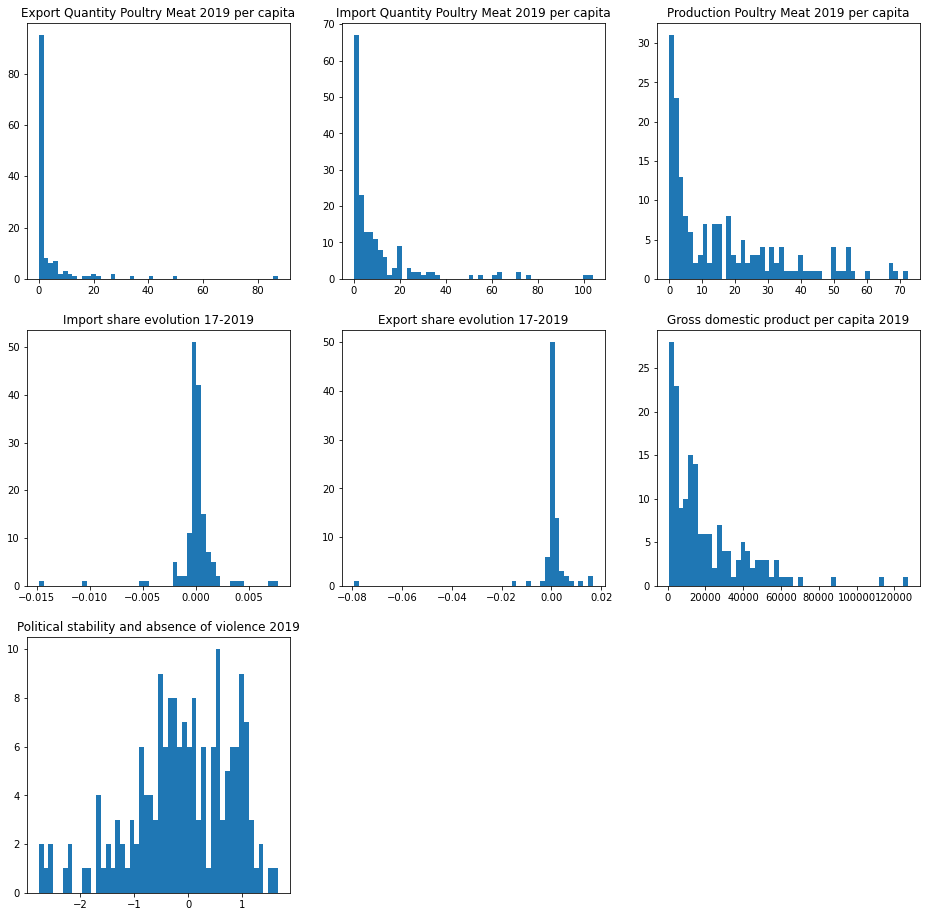

In [53]:
fig = plt.figure(figsize=(16, 16))
i=1
for col in col_null_after_join : 
    ax = fig.add_subplot(3,3,i)
    ax.hist(df_final[col], bins = 50)
    ax.set_title(col)
    i+=1
plt.show()

In [54]:

for col in col_null_after_join :
    df_final[col].fillna(0, inplace = True)

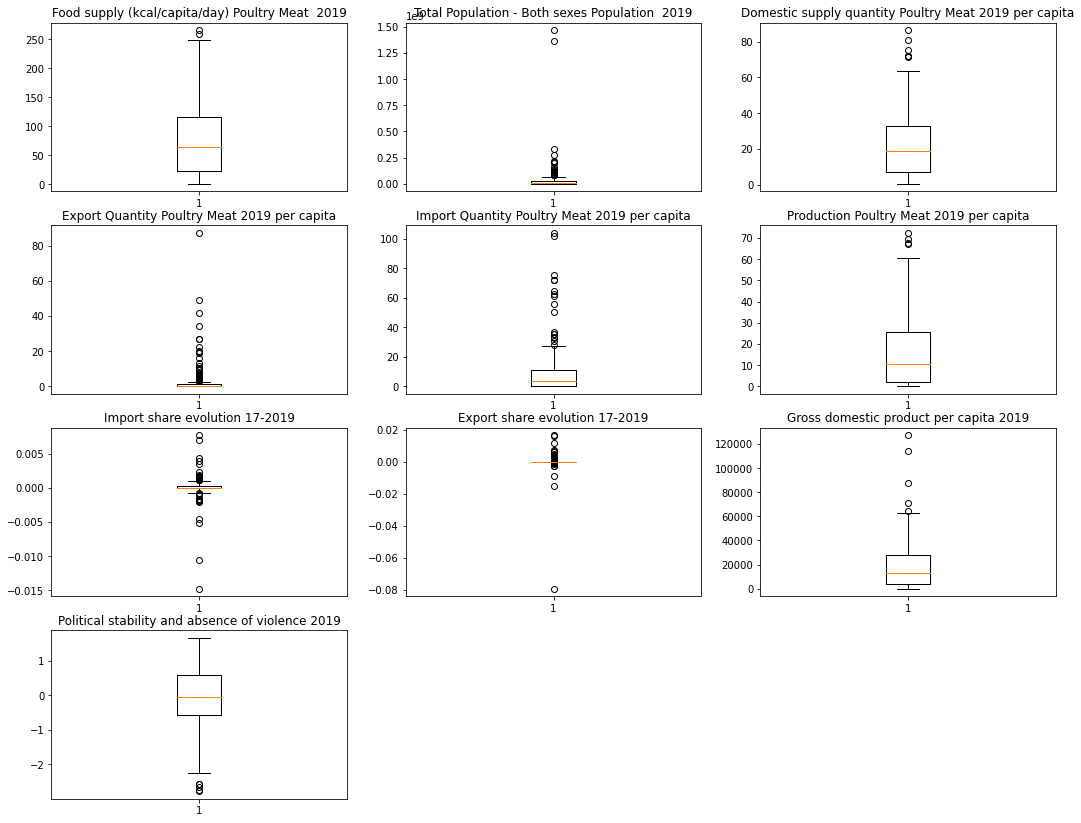

In [55]:
#visualisation des dispertion des variables : la majorité des variables présentent des outliers
fig = plt.figure(figsize=(18, 18))
i=1
for col in df_final.columns :
    ax = fig.add_subplot(5,3,i)
    ax.boxplot(df_final[col])
    ax.set_title(col)
    i+=1
plt.show()

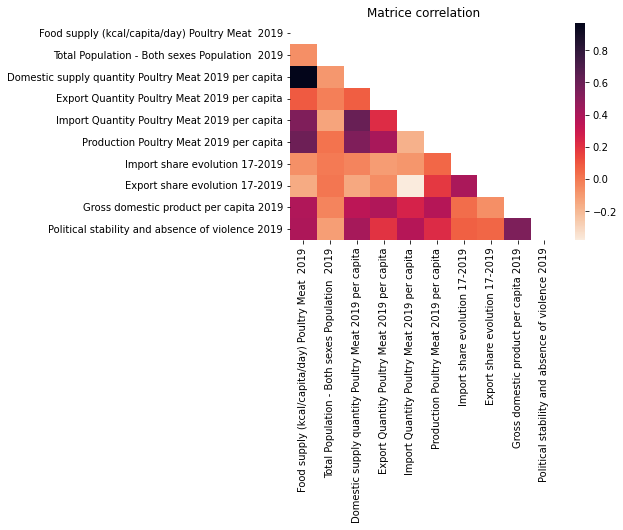

In [56]:
# générer un masque pour le triangle des corrélations entre variables
mask = np.triu(np.ones_like(df_final.corr(), dtype=bool))
#affichage de la corrélation entre variables
corr_matrice = plt.figure()
cmap = sns.cm.rocket_r
sns.heatmap(df_final.corr(), mask = mask, cmap =cmap)
plt.title("Matrice correlation")
plt.show()

On constate quer certaines variables sont fortement corrélées :


*disponibilité intérieure, corrélée positivement avec :  import, production, population, anticorrelé avec l'évolution des exports (parts du marché international)

*export (quantités), corrélée positivement avec : production

*imports (quantités), corrélée positivement avec :  disponibilité intérieure anticorrelé avec l'évolution des exports (parts du marché international)

*production, corrélée positivement avec : disponibilité intérieure, export (quantité), anticorrelé avec l'import

*évolution des imports (parts du marché international), corrélée positivement avec : l'évolution des exports (parts du marché international)

*évolution des exports (parts du marché international) anticorrélé avec : imports (quantité)


# II. Identification des principaux pays acteurs de la filière volaille
### 2.1 Principaux pays producteurs (en tonnes)

In [57]:
dispo_alimentaire.sort_values(by = "Production Poultry Meat 2019 per capita", ascending = False).head(20)["Production Poultry Meat 2019 per capita"]

Area
Israel                              72.426341
United States of America            69.463480
Poland                              67.514780
Brazil                              66.984127
Netherlands                         60.595426
Barbados                            55.749129
Hungary                             54.930305
Peru                                54.229468
Belize                              53.846154
Malaysia                            53.740219
Panama                              52.755535
Australia                           50.708249
Argentina                           50.199862
New Zealand                         50.177713
Guyana                              49.808429
Belarus                             49.407533
Jamaica                             45.454545
Trinidad and Tobago                 44.444444
Bolivia (Plurinational State of)    42.908017
Chile                               40.576192
Name: Production Poultry Meat 2019 per capita, dtype: float64

### 2.2 Principaux pays exportateurs (en tonnes)


In [58]:
dispo_alimentaire.sort_values(by = "Export Quantity Poultry Meat 2019 per capita", ascending = False).head(20)["Export Quantity Poultry Meat 2019 per capita"]

Area
Netherlands                 87.325262
Belgium                     48.964382
China, Hong Kong SAR        41.689080
Poland                      34.153294
Hungary                     26.742385
Denmark                     26.680527
Lithuania                   22.463768
Ireland                     19.868906
Brazil                      19.421938
Belarus                     18.726196
Slovenia                    15.873016
Thailand                    13.227817
United States of America    11.319952
Latvia                      10.487677
Estonia                      9.803922
Austria                      9.715243
Chile                        9.128324
Germany                      7.711005
Slovakia                     7.146784
Ukraine                      6.728190
Name: Export Quantity Poultry Meat 2019 per capita, dtype: float64

### 2.3 Principaux pays importateurs (en tonnes)

In [59]:
dispo_alimentaire.sort_values(by = "Import Quantity Poultry Meat 2019 per capita", ascending = False).head(20)["Import Quantity Poultry Meat 2019 per capita"]

Area
China, Hong Kong SAR                103.953739
Samoa                               101.522843
Saint Kitts and Nevis                75.471698
Antigua and Barbuda                  72.164948
Saint Vincent and the Grenadines     72.072072
Bahamas                              64.267352
Grenada                              62.500000
French Polynesia                     60.931900
Dominica                             55.555556
China, Macao SAR                     50.000000
Kuwait                               36.605657
New Caledonia                        35.335689
Netherlands                          35.210856
Gabon                                33.133916
Suriname                             32.702238
Seychelles                           30.612245
Belgium                              27.732039
Saint Lucia                          27.322404
Cuba                                 25.941939
Latvia                               25.170425
Name: Import Quantity Poultry Meat 2019 per capita, dty

### 2.4 Pays ayant gagné le plus de points en parts d'imports internationaux entre 2017 et 2019

In [60]:
dispo_alimentaire.sort_values(by = "Import share evolution 17-2019", ascending = False).head(20)["Import share evolution 17-2019"]

Area
Samoa                        0.007745
China, Macao SAR             0.007009
Kiribati                     0.004363
Slovakia                     0.004003
French Polynesia             0.003573
Sao Tome and Principe        0.002296
Lesotho                      0.001967
Gambia                       0.001830
Latvia                       0.001694
Estonia                      0.001581
New Caledonia                0.001555
Kuwait                       0.001549
Armenia                      0.001427
Libya                        0.001370
Lithuania                    0.001237
China, Taiwan Province of    0.001202
Fiji                         0.001174
Hungary                      0.001011
Yemen                        0.000991
Republic of Moldova          0.000935
Name: Import share evolution 17-2019, dtype: float64

### 2.5 Pays ayant gagné le plus de points en parts d'exports internationaux entre 2017 et 2019

In [61]:
dispo_alimentaire.sort_values(by = "Export share evolution 17-2019", ascending = False).head(20)["Export share evolution 17-2019"]

Area
Netherlands          0.016610
Poland               0.016035
Hungary              0.011809
Denmark              0.007134
Belarus              0.006608
Chile                0.005890
Slovenia             0.005027
Thailand             0.004429
Estonia              0.003598
Romania              0.002745
Ireland              0.002733
Austria              0.002575
Turkey               0.002354
Slovakia             0.002347
Spain                0.001856
Ukraine              0.001763
Greece               0.001744
Namibia              0.001682
Republic of Korea    0.001613
Latvia               0.001574
Name: Export share evolution 17-2019, dtype: float64

### 2.6 Pays ayant perdu le plus de points en parts d'imports internationaux entre 2017 et 2019

In [62]:
dispo_alimentaire.sort_values(by = "Import share evolution 17-2019").head(20)["Import share evolution 17-2019"]

Area
Saint Lucia                        -0.014790
China, Hong Kong SAR               -0.010585
Saint Vincent and the Grenadines   -0.005081
Iraq                               -0.004525
Oman                               -0.002034
Bahamas                            -0.001932
Gabon                              -0.001906
Saudi Arabia                       -0.001838
Maldives                           -0.001820
Tajikistan                         -0.001587
Liberia                            -0.001539
Solomon Islands                    -0.000996
Montenegro                         -0.000831
Cuba                               -0.000802
Antigua and Barbuda                -0.000714
Ireland                            -0.000702
Saint Kitts and Nevis              -0.000674
Belarus                            -0.000617
Timor-Leste                        -0.000598
Egypt                              -0.000541
Name: Import share evolution 17-2019, dtype: float64

### 2.7 Pays ayant perdu le plus de points en parts d'exports internationaux entre 2017 et 2019

In [63]:
dispo_alimentaire.sort_values(by = "Export share evolution 17-2019").head(20)["Export share evolution 17-2019"]

Area
China, Hong Kong SAR        -0.079279
Suriname                    -0.015007
Belgium                     -0.009045
Oman                        -0.002570
Portugal                    -0.002505
New Zealand                 -0.001510
France                      -0.000834
Kuwait                      -0.000821
Czechia                     -0.000761
Lebanon                     -0.000738
Panama                      -0.000417
Saudi Arabia                -0.000408
South Africa                -0.000397
Switzerland                 -0.000385
Canada                      -0.000383
China                       -0.000347
Costa Rica                  -0.000315
Georgia                     -0.000310
El Salvador                 -0.000253
China, Taiwan Province of   -0.000195
Name: Export share evolution 17-2019, dtype: float64

# Principaux pays acteurs de la filière volaille
L'Israël, USA et la Plogne sont les trois principaux producteurs mondiaux.

Les Pays-Bas et la Belgique, sont des les principaux exportateurs mondiaux, avec Hong Kong qui aussi est le principal importateur mondial.

    *La Pologne et l'Hongrie se distinguent également comme principaux pays exportateurs, derrière la Belgique et Hong kong.
    
    *Les Samoa et Saint-Kitts-et-Nevis ont eux des quantité d'import très importantes, et se situent derrière Hong kong.
    
Les pays ayant le plus progressé en termes d'exports sont la Pologne, l'Hongrie, qui sont déjà des acteurs importants sur le marché de l'export de volail (respectivmeent 4ème et 5ème en quantité d'exports mondiaux). A l'inverse, les pays ayant le plus diminué leurs parts d'exports internationaux sont Hong Kong, la Belgique .

Concernant les évolutions de parts de marché entre 2017 et 2019, le pays ayant le plus progressé en termes d'imports est Macao (10ème pays importateur en quantité) et Kiribati. A l'inverse, les pays ayant le plus diminué leurs parts d'imports internationaux sont Sainte-Lucie, Hong Kong et Saint-Vincent and les Grenadines (respectivmeent 17éme, 1er et 5ème pays importateur en quantité).



## III. Réalisation du clustering CAH et Kmeans
### 3.1 Préparation des données

In [64]:
df_final.columns

Index(['Food supply (kcal/capita/day) Poultry Meat  2019',
       'Total Population - Both sexes Population  2019',
       'Domestic supply quantity Poultry Meat 2019 per capita',
       'Export Quantity Poultry Meat 2019 per capita',
       'Import Quantity Poultry Meat 2019 per capita',
       'Production Poultry Meat 2019 per capita',
       'Import share evolution 17-2019', 'Export share evolution 17-2019',
       'Gross domestic product per capita 2019',
       'Political stability and absence of violence 2019'],
      dtype='object')

In [65]:
# préparation des données pour clustering et ACP
X = df_final.values
names = df_final.index
features = df_final.columns

In [66]:
#centrage et réduction des valeurs
X_scaled = preprocessing.StandardScaler().fit_transform(X)

### 3.2 Dendrogramme

In [67]:
#générer la matrice des liens, utilisation de la méthode de Ward
Z = linkage(X_scaled, method='ward', metric='euclidean')

<Figure size 1080x1080 with 0 Axes>

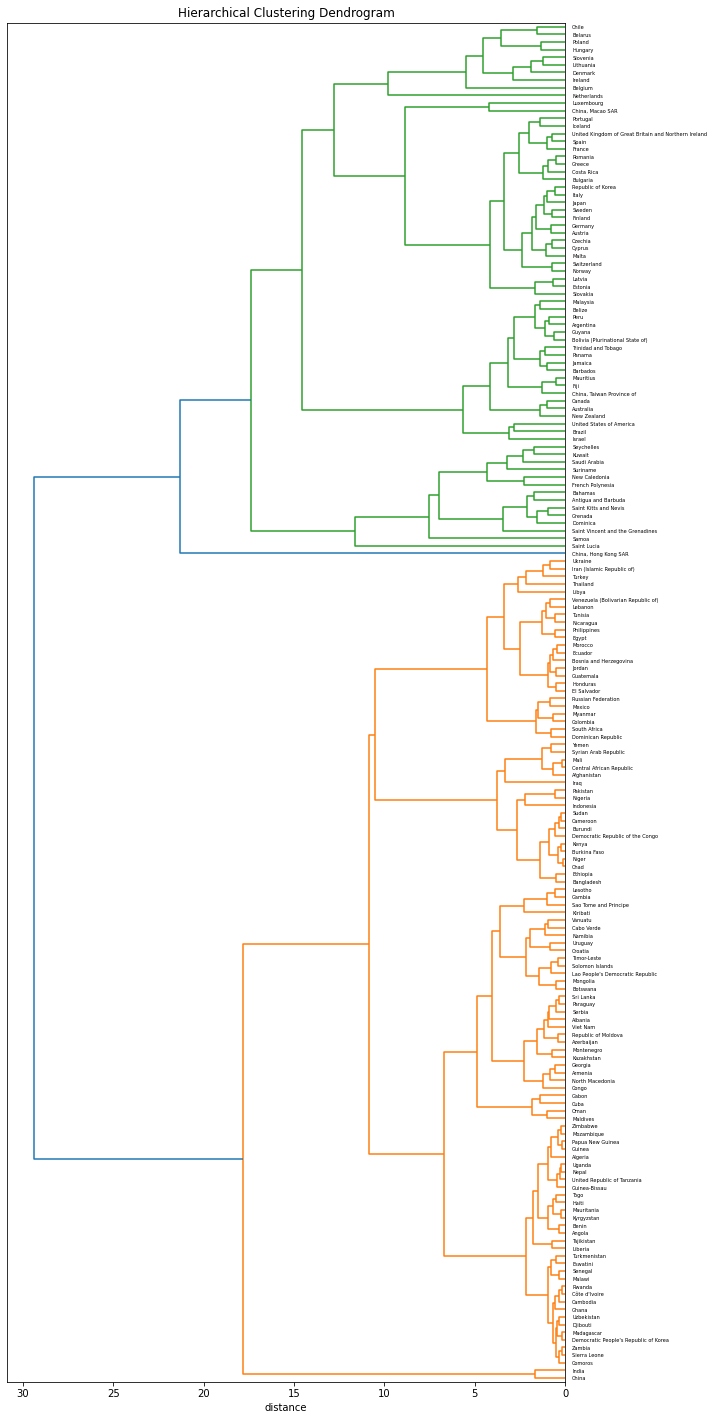

In [68]:
# affichage du dendrogramme
fig = plt.figure(figsize = (15,15))
plot_dendrogram(Z, names)

### 3.3 Calcul des coefficients de silhouette et DB scores
-Coefficient de silhouette

-Davies–Bouldin (DB) score pour un nombre de cluster entre 3 et 12, pour la méthode CAH et le Kmeans

In [69]:
#calcul des indicateurs pour la méthode CAH
db_CAH, slc_CAH = {}, {}
for i in range (3,12) :
    clusters_CAH = fcluster(Z, i, criterion='maxclust')
    slc_CAH[i] = metrics.silhouette_score(X_scaled, clusters_CAH)
    db_CAH[i] = metrics.davies_bouldin_score(X_scaled, clusters_CAH)

In [70]:
#calcul des indicateurs pour la méthode Kmeans
inertia, db_km, slc_km = {}, {}, {}
for i in range (3,12) :
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    clusters_km = kmeans.labels_
    inertia[i] = kmeans.inertia_
    slc_km[i] = metrics.silhouette_score(X_scaled, clusters_km)
    db_km[i] = metrics.davies_bouldin_score(X_scaled, clusters_km)

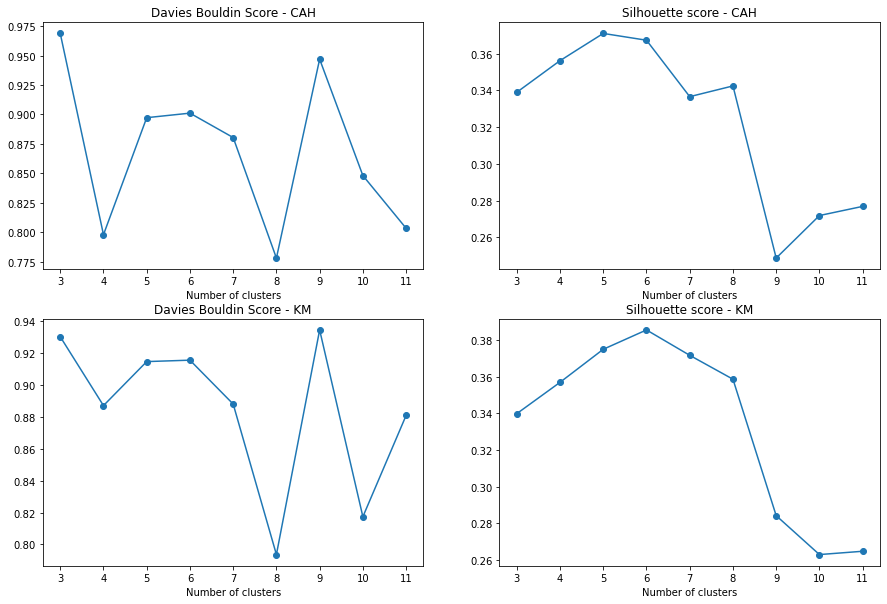

In [71]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(db_CAH.keys(), list(db_CAH.values()), marker='o')
ax1.set_title("Davies Bouldin Score - CAH")
ax1.set_xlabel("Number of clusters")
ax2.plot(slc_CAH.keys(), list(slc_CAH.values()), marker='o' )
ax2.set_title("Silhouette score - CAH")
ax2.set_xlabel("Number of clusters")
ax3.plot(db_km.keys(), list(db_km.values()), marker='o')
ax3.set_title("Davies Bouldin Score - KM")
ax3.set_xlabel("Number of clusters")
ax4.plot(slc_km.keys(), list(slc_km.values()), marker='o')
ax4.set_title("Silhouette score - KM")
ax4.set_xlabel("Number of clusters")
plt.show()

Les indicateurs CAH donnent de meilleurs scores pour un nombre de cluster égale à 5 ou 6 ou 8

Les ndicateurs KM donnent de meilleurs scores pour un nombre de cluster égale à 5 ou 6 ou 7

On fixe le nombre de clusters à 6

### 3.4 Clustering CAH

In [72]:
#définition des clusters par la méthode CAH
clusters_CAH = fcluster(Z, 6, criterion='maxclust')

In [73]:
#les numéro de cluster sont ajoutés au df
df_final["cluster CAH"] = clusters_CAH

### 3.5 Clustering Kmeans

In [74]:
#définition des clusters par la méthode Kmeans
#nombre de clusters souhaités
n_clust = 6

# clustering par K-means, ici pour récupérer les coordonnées des centroides calculés, 
#pour initialisation du kmeans avec init dans un second temps
km_get_centroïdes = KMeans(n_clusters=n_clust, random_state=0)
km_get_centroïdes.fit(X_scaled)

# récupération des coordonnées des centroïdes pour utilisation dans init
centroids_after_kmeans_get_centroides = km_get_centroïdes.cluster_centers_

In [75]:
centroids_after_kmeans_get_centroides

array([[ 1.32345986e+00, -1.20449680e-02,  1.19981988e+00,
        -1.17794569e-01, -2.04541913e-01,  1.43184264e+00,
        -2.35702218e-01, -3.55271626e-02,  1.96793461e-01,
         2.63582195e-01],
       [-6.38569559e-01, -9.57907613e-02, -6.27967748e-01,
        -2.78128817e-01, -3.13476313e-01, -5.48496372e-01,
         1.29886385e-02,  1.84923692e-02, -5.68970390e-01,
        -4.99030577e-01],
       [ 1.48345609e-01, -1.50149615e-01,  1.37820656e-01,
         8.49233388e-01,  1.73275072e-01,  5.10725375e-01,
         2.97289904e-01,  3.19217049e-01,  1.40577534e+00,
         9.53282545e-01],
       [-5.90613173e-01,  8.90964569e+00, -7.20531859e-01,
        -2.94538526e-01, -5.64665181e-01, -4.22708459e-01,
        -7.33318141e-04, -2.67094716e-02, -3.72204004e-01,
        -2.58076449e-01],
       [ 2.13524653e+00, -2.31542562e-01,  1.94652269e+00,
         4.10116417e+00,  5.30644045e+00, -7.77393047e-01,
        -5.75613707e+00, -1.21841765e+01,  1.95066720e+00,
        -1.

In [76]:
#création d'un np array avec les coordonnées des centroïdes
centroids_after_kmeans_get_centroides = np.array([[ 1.32345986e+00, -1.20449680e-02,  1.19981988e+00,
        -1.17794569e-01, -2.04541913e-01,  1.43184264e+00,
        -2.35702218e-01, -3.55271626e-02,  1.96793461e-01,
         2.63582195e-01],
       [-6.38569559e-01, -9.57907613e-02, -6.27967748e-01,
        -2.78128817e-01, -3.13476313e-01, -5.48496372e-01,
         1.29886385e-02,  1.84923692e-02, -5.68970390e-01,
        -4.99030577e-01],
       [ 1.48345609e-01, -1.50149615e-01,  1.37820656e-01,
         8.49233388e-01,  1.73275072e-01,  5.10725375e-01,
         2.97289904e-01,  3.19217049e-01,  1.40577534e+00,
         9.53282545e-01],
       [-5.90613173e-01,  8.90964569e+00, -7.20531859e-01,
        -2.94538526e-01, -5.64665181e-01, -4.22708459e-01,
        -7.33318141e-04, -2.67094716e-02, -3.72204004e-01,
        -2.58076449e-01],
       [ 2.13524653e+00, -2.31542562e-01,  1.94652269e+00,
         4.10116417e+00,  5.30644045e+00, -7.77393047e-01,
        -5.75613707e+00, -1.21841765e+01,  1.95066720e+00,
        -1.71828887e-01],
       [ 2.06690477e+00, -2.78736569e-01,  2.51691948e+00,
        -3.27496962e-01,  3.40917724e+00, -7.87598501e-01,
         1.32884012e-01, -2.64151490e-04, -1.27216232e-01,
         1.01272748e+00]])

In [77]:
# clustering par K-means avec initialisation des centroïdes aux coordonnées précedemment calculées
km = KMeans(n_clusters=n_clust, init = centroids_after_kmeans_get_centroides, max_iter= 500)
km.fit(X_scaled)

# récupération des clusters attribués à chaque individu et des coordonnées des centroïdes
clusters_km = km.labels_
centroids_after_kmeans = km.cluster_centers_

/Users/fabienmirosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [78]:
#les numéro de cluster sont ajoutés au df
df_final["cluster kmeans"] = clusters_km

### 3.6 Etude de la concordance entre les clusters issus de la CAH et du Kmeans

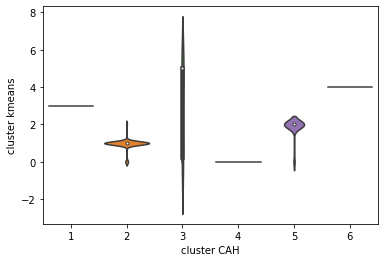

In [79]:
# recherche de la concordance des libellés des clusters CAH vs kmeans
sns.violinplot(x="cluster CAH", y="cluster kmeans", data=df_final[["cluster CAH","cluster kmeans"]])
plt.show()

In [80]:
# on attribue les mêmes numéros de cluster CAH et Kmeans 
for element in zip([3,1,5,0,2,4], [1,2,3,4,5,6]) :
    df_final.loc[df_final['cluster kmeans'] == element[0], 'cluster kmeans new'] = element[1]

In [81]:
#conversion des données kmeans new en entier
df_final["cluster kmeans new"] = df_final["cluster kmeans new"].astype(int)

In [82]:
df_final.head()

,Food supply (kcal/capita/day) Poultry Meat 2019,Total Population - Both sexes Population 2019,Domestic supply quantity Poultry Meat 2019 per capita,Export Quantity Poultry Meat 2019 per capita,Import Quantity Poultry Meat 2019 per capita,Production Poultry Meat 2019 per capita,Import share evolution 17-2019,Export share evolution 17-2019,Gross domestic product per capita 2019,Political stability and absence of violence 2019,cluster CAH,cluster kmeans,cluster kmeans new
Area,,,,,,,,,,,,,
Afghanistan,6.0,38042000.0,1.761211,0.000000,1.156616,0.736029,0.000191,0.0,2065.0,-2.65,2,1,2
Albania,61.0,2881000.0,11.801458,0.000000,7.636237,4.165220,0.000382,0.0,13671.5,0.12,2,1,2
Algeria,23.0,43053000.0,6.666202,0.023227,0.000000,6.759111,0.000000,0.0,11510.6,-1.00,2,1,2
Angola,34.0,31825000.0,10.274941,0.000000,8.735271,1.539670,-0.000283,0.0,6670.3,-0.31,2,1,2
Antigua and Barbuda,265.0,97000.0,72.164948,0.000000,72.164948,0.000000,-0.000714,0.0,21548.7,0.96,3,5,3


### 3.7 Liste des pays par cluster
On constate que les indivisus composants les clusters par méthode CAH ou par méthode Kmeans sont quasiment les mêmes

In [83]:
for value in [1,2,3,4,5,6] :
    print(f'Liste des pays cluster {value} par méthode CAH : ')
    print(df_final[df_final["cluster CAH"] == value].index)
    print(f'Liste des pays cluster {value} par méthode Kmeans : ')
    print(df_final[df_final["cluster kmeans new"] == value].index)
    print(" ")

Liste des pays cluster 1 par méthode CAH : 
Index(['China', 'India'], dtype='object', name='Area')
Liste des pays cluster 1 par méthode Kmeans : 
Index(['China', 'India'], dtype='object', name='Area')
 
Liste des pays cluster 2 par méthode CAH : 
Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Azerbaijan',
       'Bangladesh', 'Benin', 'Bosnia and Herzegovina', 'Botswana',
       ...
       'Ukraine', 'United Republic of Tanzania', 'Uruguay', 'Uzbekistan',
       'Vanuatu', 'Venezuela (Bolivarian Republic of)', 'Viet Nam', 'Yemen',
       'Zambia', 'Zimbabwe'],
      dtype='object', name='Area', length=106)
Liste des pays cluster 2 par méthode Kmeans : 
Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Armenia', 'Azerbaijan',
       'Bangladesh', 'Benin', 'Bosnia and Herzegovina', 'Botswana',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Cuba',
       'Côte d'Ivoire', 'Democ

In [84]:
df_final['cluster CAH'].unique()

array([2, 3, 4, 5, 1, 6], dtype=int32)

In [85]:
df = df_final.copy()

### 3.8 Représentation des clusters sur la carte
On utilise le geodataframe geopandas

In [86]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#antarctique enlevée de la carte pour esthétique : 
world.drop(index=159, inplace=True)

In [87]:
world.shape
# 176 pays vs 178 dans notre df_final

(176, 6)

In [88]:
#certains intitulés de pays / zones ne concordent pas
set(df_final.index) - set(world["name"])

{'Antigua and Barbuda',
 'Barbados',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Cabo Verde',
 'Central African Republic',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'China, Taiwan Province of',
 'Comoros',
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Dominica',
 'Dominican Republic',
 'Eswatini',
 'French Polynesia',
 'Grenada',
 'Iran (Islamic Republic of)',
 'Kiribati',
 "Lao People's Democratic Republic",
 'Maldives',
 'Malta',
 'Mauritius',
 'North Macedonia',
 'Republic of Korea',
 'Republic of Moldova',
 'Russian Federation',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Vincent and the Grenadines',
 'Samoa',
 'Sao Tome and Principe',
 'Seychelles',
 'Solomon Islands',
 'Syrian Arab Republic',
 'United Kingdom of Great Britain and Northern Ireland',
 'United Republic of Tanzania',
 'Venezuela (Bolivarian Republic of)',
 'Viet Nam'}

certains intitulés de pays diffèrent entre le geodataframe et le df_final : - utilisation des codes ISO pour fusion des deux dataframe - recuperation des codes iso a3 https://www.fao.org/nocs/en

In [89]:
# df assurant la concordance nom du pays - code iso A3
isoa3 = pd.read_csv("iso_a3_codes.csv", sep = ";", index_col="LIST NAME")
isoa3.head()

,ISO3
LIST NAME,
Afghanistan,AFG
Akrotiri and Dhekelia,NaN
Albania,ALB
Algeria,DZA
American Samoa,ASM


In [90]:
#jointure gauche entre le df_final et les codes iso A3
df_final = df_final.join(isoa3)
df_final.rename(columns={"ISO3": "iso_a3"}, inplace= True)

In [91]:
df_final[df_final["iso_a3"].isnull()]
# le code de Taiwan n'a pas été trouvé

,Food supply (kcal/capita/day) Poultry Meat 2019,Total Population - Both sexes Population 2019,Domestic supply quantity Poultry Meat 2019 per capita,Export Quantity Poultry Meat 2019 per capita,Import Quantity Poultry Meat 2019 per capita,Production Poultry Meat 2019 per capita,Import share evolution 17-2019,Export share evolution 17-2019,Gross domestic product per capita 2019,Political stability and absence of violence 2019,cluster CAH,cluster kmeans,cluster kmeans new,iso_a3
Area,,,,,,,,,,,,,,
"China, Taiwan Province of",146.0,23774000.0,38.781863,0.210314,9.043493,30.747876,0.001202,-0.000195,0.0,0.72,4,0,4,NaN


In [92]:
#il est défini manuellement
df_final["iso_a3"].fillna("TWN", inplace= True)

In [93]:
#pays dont les codes sont présents dans le df_final mais pas dans le geodataframe
codes_not_found = set(df_final["iso_a3"]) - set(world["iso_a3"])
df_final[df_final["iso_a3"].isin(list(codes_not_found))].index

Index(['Antigua and Barbuda', 'Barbados', 'Cabo Verde', 'China, Hong Kong SAR',
       'China, Macao SAR', 'Comoros', 'Dominica', 'France', 'French Polynesia',
       'Grenada', 'Kiribati', 'Maldives', 'Malta', 'Mauritius', 'Norway',
       'Saint Kitts and Nevis', 'Saint Lucia',
       'Saint Vincent and the Grenadines', 'Samoa', 'Sao Tome and Principe',
       'Seychelles'],
      dtype='object', name='Area')

In [94]:
#pays dont les codes sont présents dans le geodataframe mais pas dans le df_final
world[world["iso_a3"].isin(list(set(world["iso_a3"]) - set(df_final["iso_a3"]) ))]['name']

2                   W. Sahara
12                    Somalia
20               Falkland Is.
21                     Norway
22                  Greenland
23     Fr. S. Antarctic Lands
43                     France
45                Puerto Rico
69                 Eq. Guinea
79                  Palestine
84       United Arab Emirates
85                      Qatar
100                    Bhutan
149                    Brunei
154                   Eritrea
160                 N. Cyprus
167                Somaliland
174                    Kosovo
176                  S. Sudan
Name: name, dtype: object

In [95]:
# 5 pays ont un code ISO A3 erroné dans le geodataframe
world[world["iso_a3"] == "-99"]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
21,5320045,Europe,Norway,-99,364700.0,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
160,265100,Asia,N. Cyprus,-99,3600.0,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
167,3500000,Africa,Somaliland,-99,12250.0,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."


In [96]:
# on défini manuellement les codes ISO A3 existants
for element in zip(["France", "Norway"], ["FRA", "NOR"]) :
    world.loc[world['name'] == element[0], 'iso_a3'] = element[1]

In [97]:
#nous ne disposons pas des données pour les pays/territoires ci dessous, qui sont donc écartés pour la représentation
world[world["iso_a3"].isin(list(set(world["iso_a3"]) - set(df_final["iso_a3"])))]['name']

2                   W. Sahara
12                    Somalia
20               Falkland Is.
22                  Greenland
23     Fr. S. Antarctic Lands
45                Puerto Rico
69                 Eq. Guinea
79                  Palestine
84       United Arab Emirates
85                      Qatar
100                    Bhutan
149                    Brunei
154                   Eritrea
160                 N. Cyprus
167                Somaliland
174                    Kosovo
176                  S. Sudan
Name: name, dtype: object

In [98]:
#projection sur les colonnes à fusionner dans le geodataframe world
clusters_col = df_final[["cluster CAH", "cluster kmeans new", "iso_a3"]]

In [99]:
#fusion du df clusters avec le geodataframe world pour affichage des clusters
world = world.merge(clusters_col, how = "left", on = "iso_a3")

In [100]:
#on vérifie la présence de nulls après fusion :
world.info()
# comme vu précédemment, nous ne possédons pas les données pour 16 territoires du geodatagrame, d'où les 16 valeurs nulles

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 176 entries, 0 to 175
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   pop_est             176 non-null    int64   
 1   continent           176 non-null    object  
 2   name                176 non-null    object  
 3   iso_a3              176 non-null    object  
 4   gdp_md_est          176 non-null    float64 
 5   geometry            176 non-null    geometry
 6   cluster CAH         159 non-null    float64 
 7   cluster kmeans new  159 non-null    float64 
dtypes: float64(3), geometry(1), int64(1), object(3)
memory usage: 12.4+ KB


In [101]:
# griser les pays n'ayant pas de cluster
world.drop(labels = world[world["cluster CAH"].isnull()].index, inplace=True)
world.drop(labels = world[world["cluster kmeans new"].isnull()].index, inplace=True)

In [102]:
#modification du type de données pour les variables cluster
world["cluster CAH"] = world["cluster CAH"].astype(int).astype(str)
world["cluster kmeans new"] = world["cluster kmeans new"].astype(int).astype(str)

Clustering issu de la classification ascendante hiérarchique


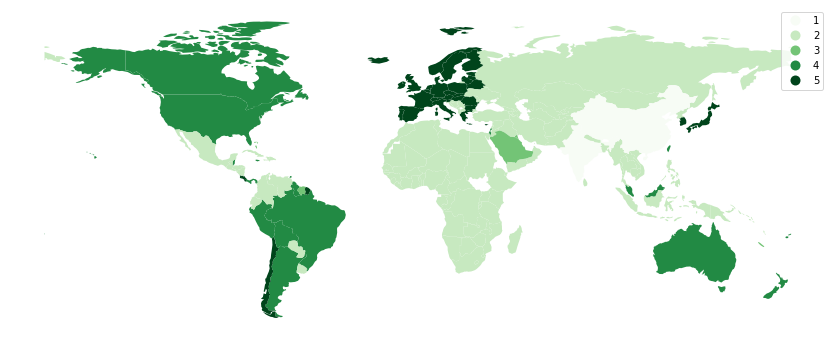

Clustering issu du Kmeans


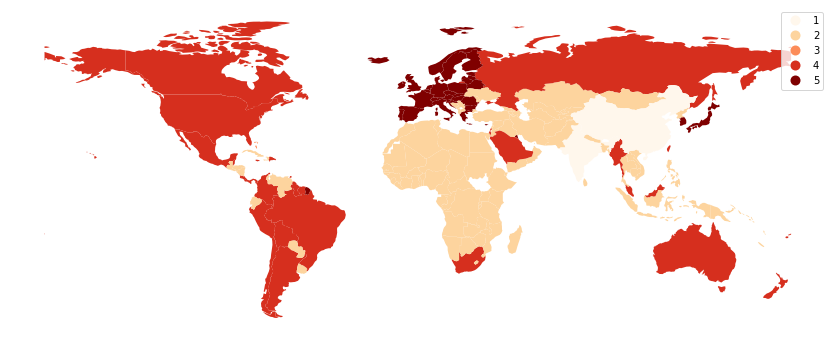

In [103]:
print("Clustering issu de la classification ascendante hiérarchique")
world.plot(column='cluster CAH', cmap='Greens', figsize=(20, 6),legend = [1,2,3,4,5,6,7]).axis('off')
plt.show()
print("Clustering issu du Kmeans")
world.plot(column='cluster kmeans new', figsize=(20, 6), cmap='OrRd', legend = [1,2,3,4,5,6,7]).axis('off')
plt.show()

### 3.8 Heatmap croisement clusters et variables

In [104]:
#calcul de la moyenne par cluster CAH et variable
means_cluster_CAH = df_final.pivot_table(index = "cluster CAH", aggfunc='mean' ).drop(columns = ["cluster kmeans", "cluster kmeans new"])

In [105]:
#standardisation des valeurs
means_cluster_CAH_scaled = preprocessing.StandardScaler().fit_transform(means_cluster_CAH)

In [106]:
#générer le dataframe avec les valeurs standardisées
means_cluster_CAH_scaled = pd.DataFrame(means_cluster_CAH_scaled, index = [1,2,3,4,5,6], columns= means_cluster_CAH.columns)

In [107]:
#calcul de la moyenne par cluster Kmeans et variable
means_cluster_kmeans = df_final.pivot_table(index = "cluster kmeans new", aggfunc='mean' ).drop(columns = ["cluster kmeans", "cluster CAH"])

In [108]:
#standardisation des valeurs
means_cluster_kmeans_scaled = preprocessing.StandardScaler().fit_transform(means_cluster_kmeans)

In [109]:
#générer le dataframe avec les valeurs standardisées
means_cluster_kmeans_scaled = pd.DataFrame(means_cluster_kmeans_scaled, index = [1,2,3,4,5,6], columns= means_cluster_kmeans.columns)

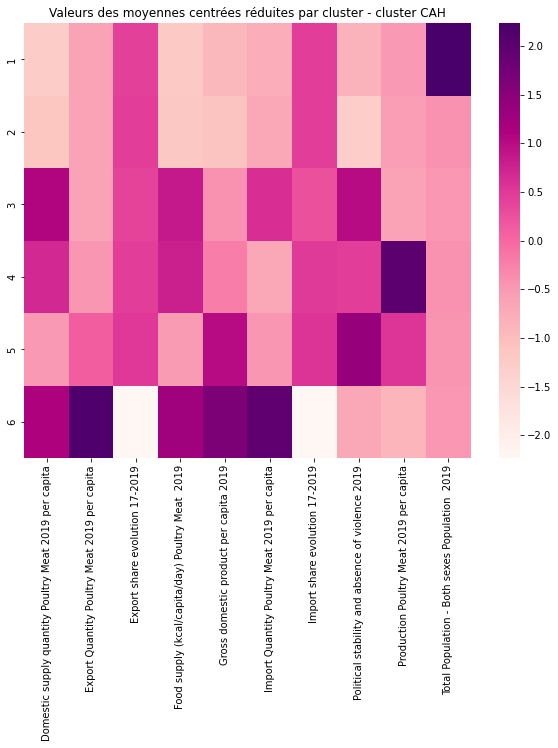

In [110]:
MCR_clusters_CAH = plt.figure(figsize = (10,8))
cmap = sns.cm.rocket_r
sns.heatmap(means_cluster_CAH_scaled, cmap ='RdPu')
plt.title("Valeurs des moyennes centrées réduites par cluster - cluster CAH")
plt.show()

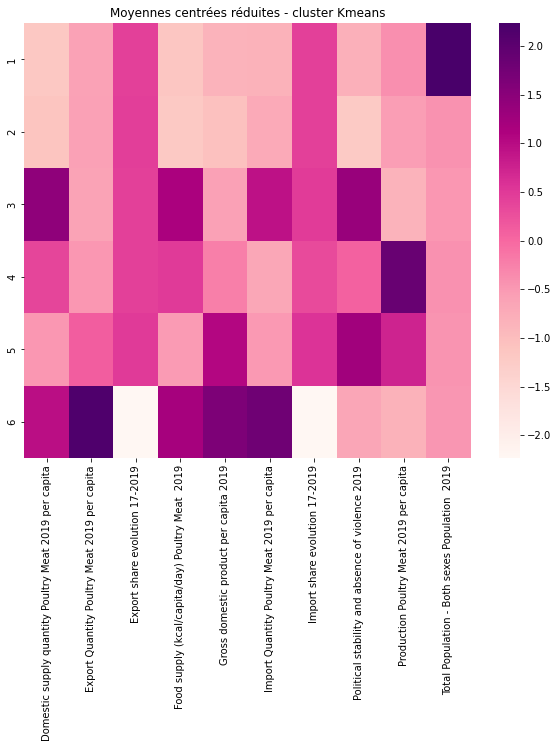

In [111]:
# générer un masque pour la matrice des corrélations
MCR_clusters_kmeans = plt.figure(figsize = (10,8))
cmap = sns.cm.rocket_r
sns.heatmap(means_cluster_kmeans_scaled, cmap ='RdPu')
plt.title("Moyennes centrées réduites - cluster Kmeans")
plt.show()

## IV. Analyse en Composantes Principales
### 3.1 Définition de l'objet PCA et affichage du graphique des éboulis des valeurs propres

In [112]:
# compte tenu du faible nombre de variables, on fixe le nombre de composantes à 6
n_comp = 6

In [113]:
#initialisation d'un objet de type PCA
pca = decomposition.PCA(n_components=n_comp)

In [114]:
pca.fit(X_scaled)

PCA(n_components=6)

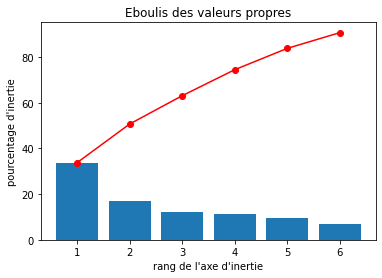

In [115]:
#affichage du graph des éboulis des valeurs propres ( = intertie de chaque composante)
display_scree_plot(pca)

Les 4 premiers plans factoriels permettent d'expliquer près de 80% de l'inertie

## 3.2 Cercle des corrélations

In [116]:
#récupération des composantes de l'objet pca
pcs = pca.components_

In [117]:
axis_ranks = [(0,1),(2,3)]
#définition des différents plans factoriels que nous souhaitons utiliser, ici 4, qui permettent d'expliquer 80% de l'inertie

In [118]:
#association des numéro aux libellés des variables
features_n = [value for value in range(1,(len(features)+1))]

In [119]:
#légende du cercle des corrélations
for element in zip(features_n, features) :
    print (element)

(1, 'Food supply (kcal/capita/day) Poultry Meat  2019')
(2, 'Total Population - Both sexes Population  2019')
(3, 'Domestic supply quantity Poultry Meat 2019 per capita')
(4, 'Export Quantity Poultry Meat 2019 per capita')
(5, 'Import Quantity Poultry Meat 2019 per capita')
(6, 'Production Poultry Meat 2019 per capita')
(7, 'Import share evolution 17-2019')
(8, 'Export share evolution 17-2019')
(9, 'Gross domestic product per capita 2019')
(10, 'Political stability and absence of violence 2019')


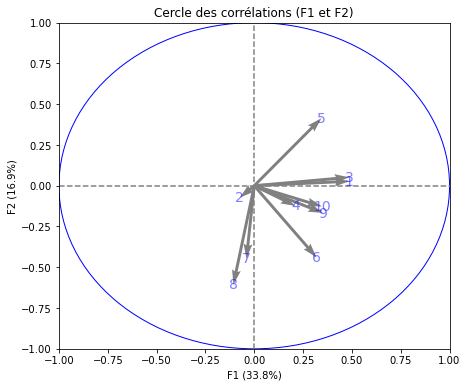

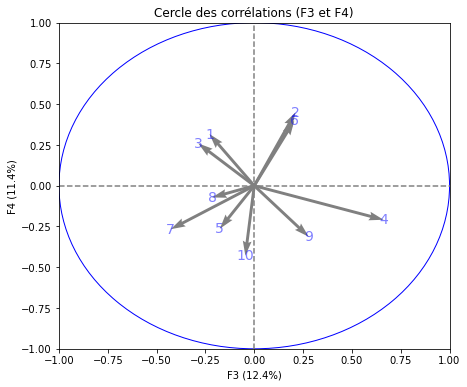

In [120]:
#cercle des corrélations
display_circles(pcs,n_comp,pca, axis_ranks, labels = features_n )

*F1 : les variables 1,2,5 soit PIB, population totale et import (quantité) sont les plus corrélées à l'axe 1, qui représente 33,8% de l'inertie totale. On peut synthétiser cette variable par la notion de taille du marché, on s'attend à retrouver les géants de la filière volaille (USA, Brésil, la pologne) à droite de cet axe

*F2 : les variables 7,8,6 soit export share evolution, import share evolution et la production sont anticorréllées à cet axe, qui représente 16,9% de l'inertie totale. On peut synthétiser cet axe par l'insécurité alimentaire du pays ou pauvreté par habitant.on peut imaginer que cet axe représente majoritairement le recul des parts sur le marché international

On s'attend à retrouver en haut de cet axe les pays à bas revenus, en bas de cet axe, les pays à hauts revenus.

*F3 : les variables 4,9, soit export (quantité) et quantité de volaille par personne par jour sont les plus corrélées à l'axe 3, qui représente 12,4% de l'inertie totale. L'axe est également anticorrélé à 7, import share evolution. On peut synthétiser cet axe comme principaux acteurs de l'export de poulet (en quantité et en progression sur le marché mondial). On s'attend à trouver à droite de cet axe des pays tels que la Belgique, pays-bas et Hong Knog.

*F4 : la variable 2,6 soit population totale et production sont corrélées tandis que la variable 10 stabilité politique est anticorrélées à l'axe 4, qui lui représente 11,4% de l'inertie total. On peut imaginer que plus un pays est instable politiquement, moins le commerce international est favorable. Compte tenu de la forte représentation de la variable import share evolution, on peut imaginer que cet axe représente majoritairement le recul des parts sur le marché international . On s'attend à retrouver en haut de cet axe les pays les plus grands producteurs et les plus stable politiquement et aussi les plus plus peuplés tels que l'Israël, la Pologne les Etat-Unis

## 3.3 Projection des individus

In [121]:
# calcul des coordonnées des individus et des centroïdes projetés
X_projected = pca.transform(X_scaled)

In [122]:
#calcul des coordonnées des centres  des individus projetés (moyenne pour chaque cluster CAH)
X_projected_df = pd.DataFrame(X_projected)

In [123]:
X_projected_df["cluster CAH"] = df_final["cluster CAH"].values

In [124]:
X_projected_df = X_projected_df.groupby(by = "cluster CAH").mean()

In [125]:
centers_CAH_clusters = X_projected_df.values

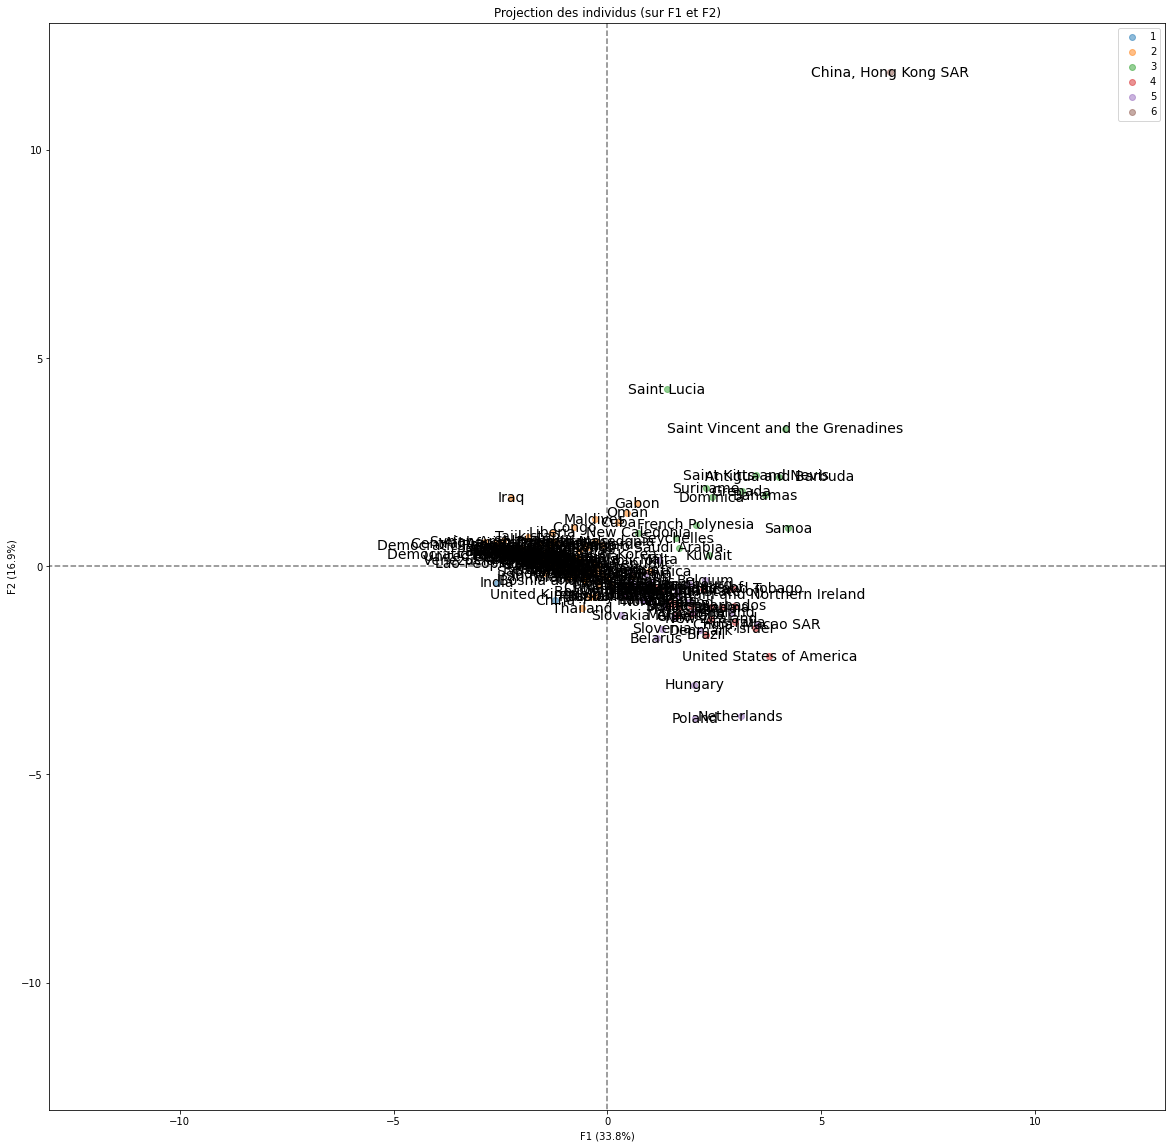

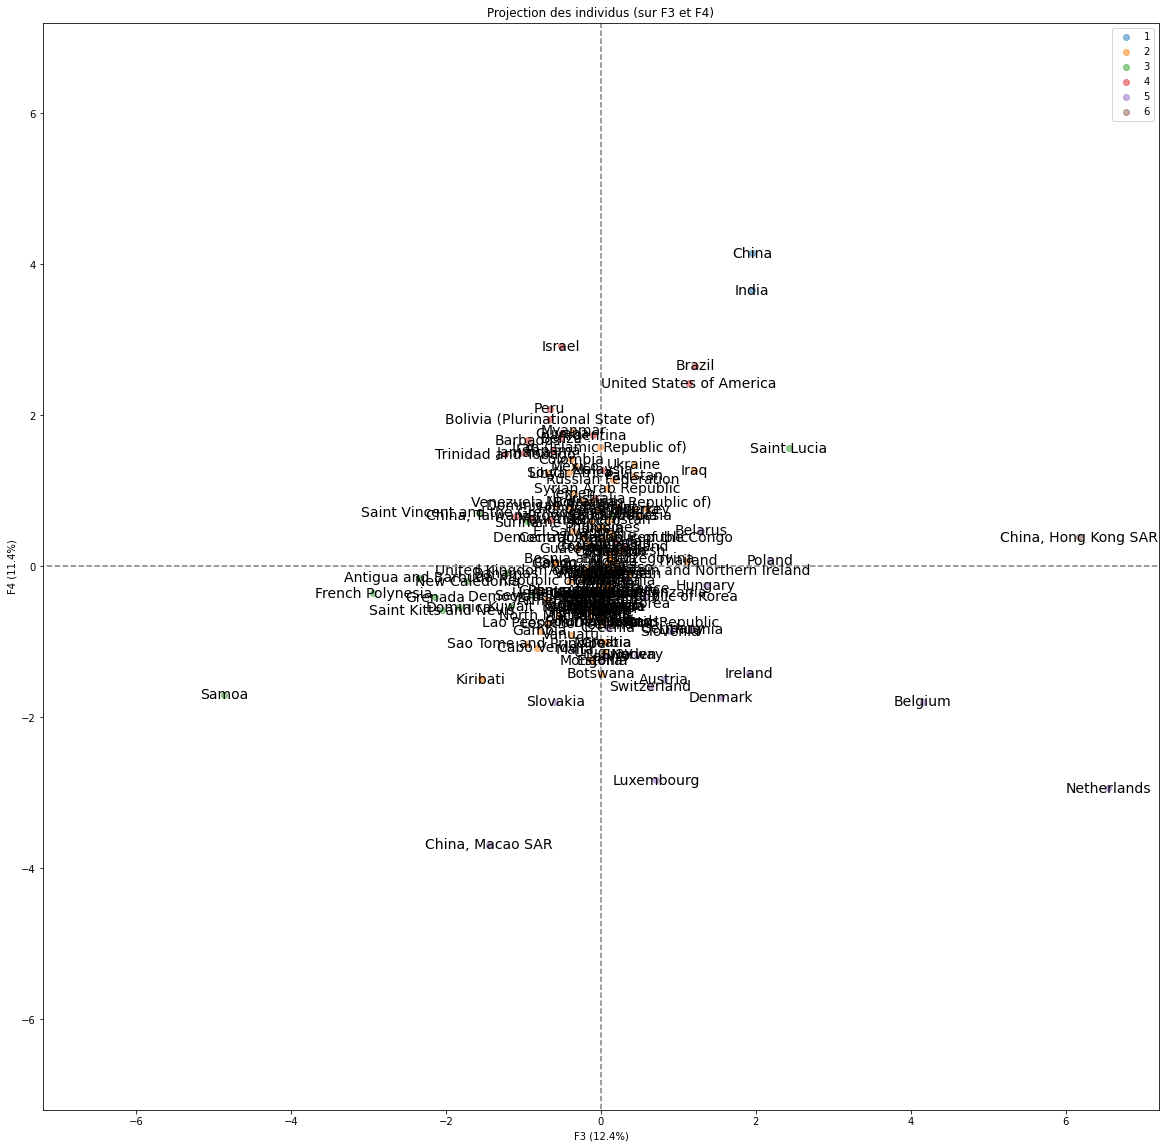

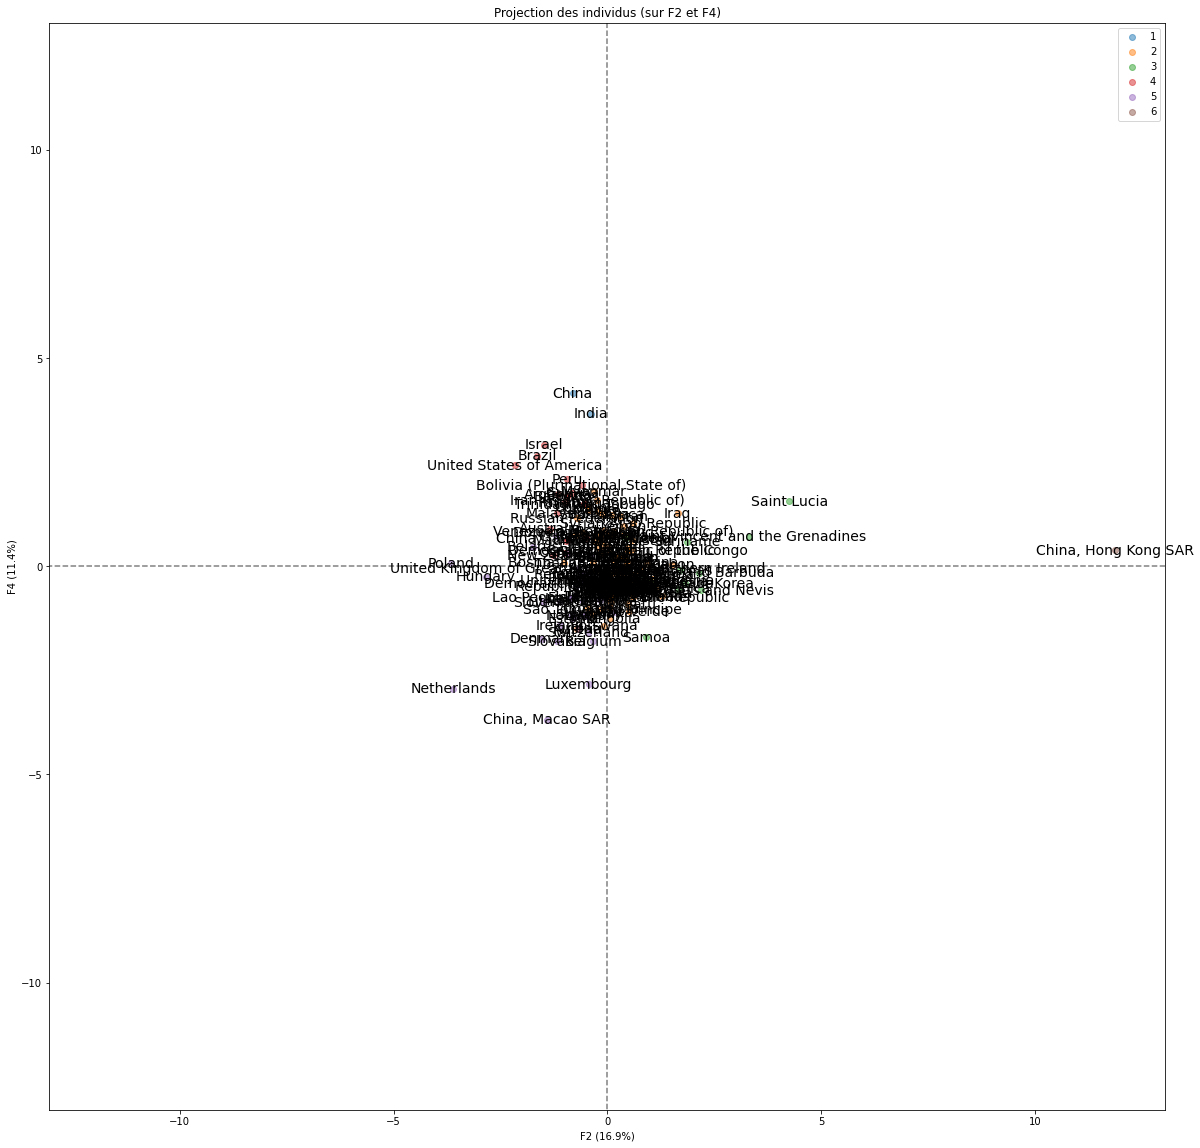

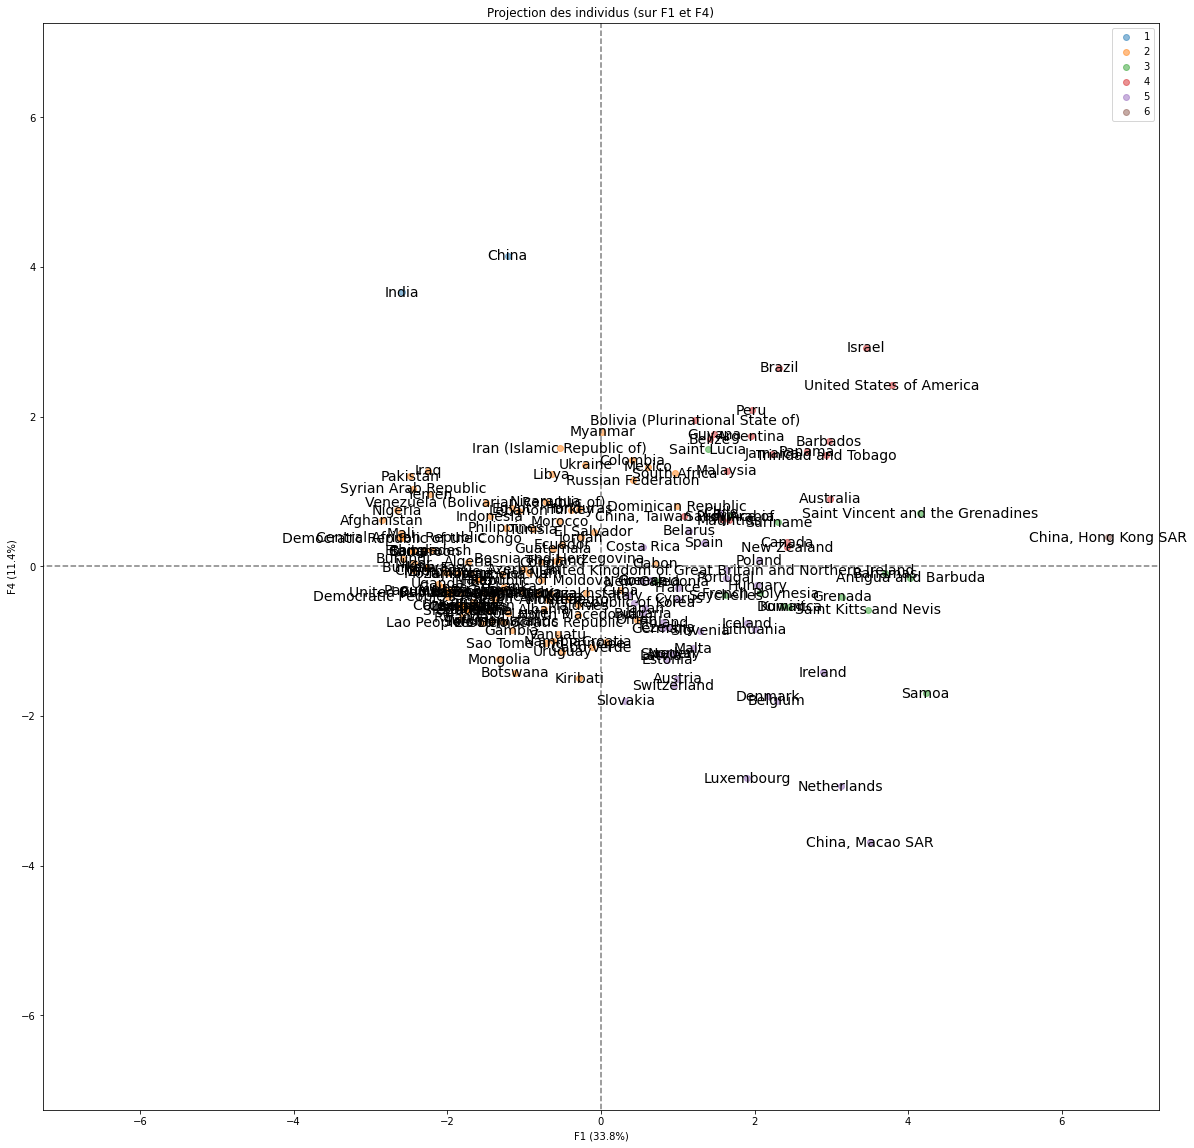

In [126]:
#Projection des individus, coloration par cluster (ici issus du CAH)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(1,3),(0,3)], labels = np.array(names),
                         illustrative_var = df_final["cluster CAH"], alpha = 0.5)

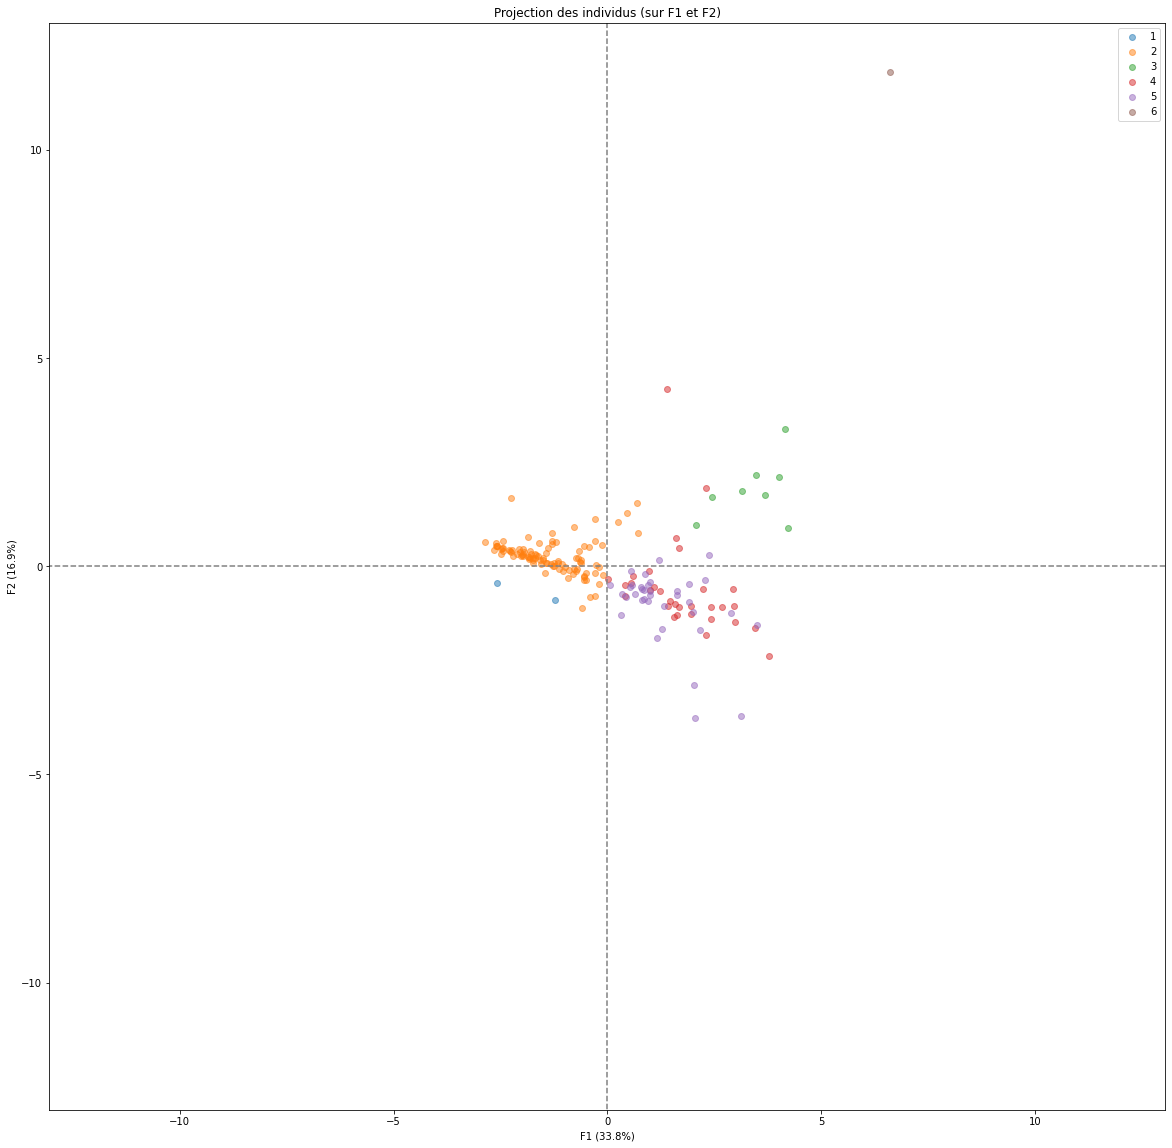

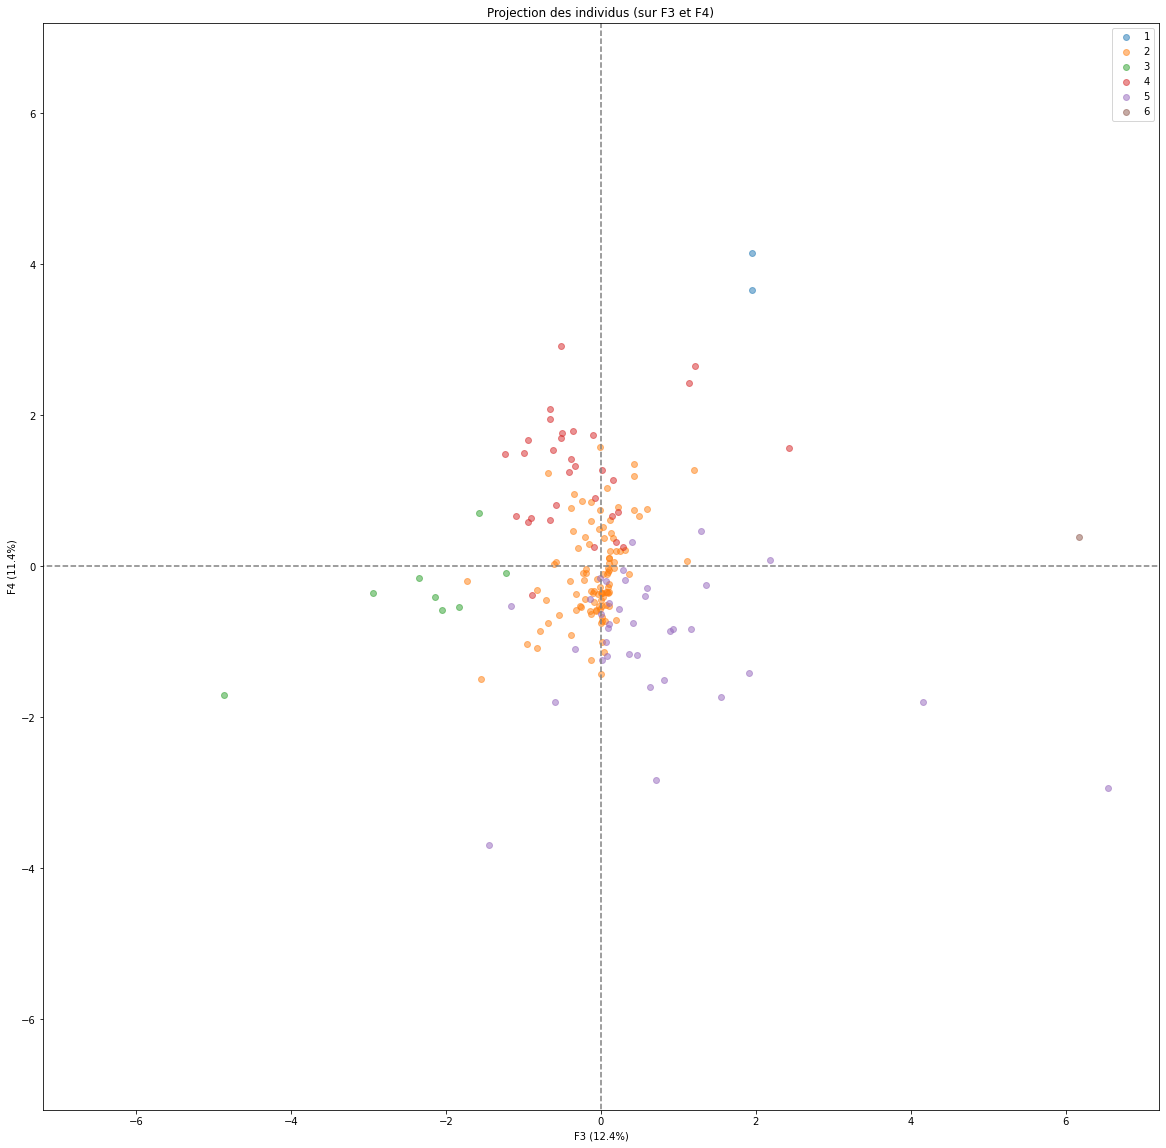

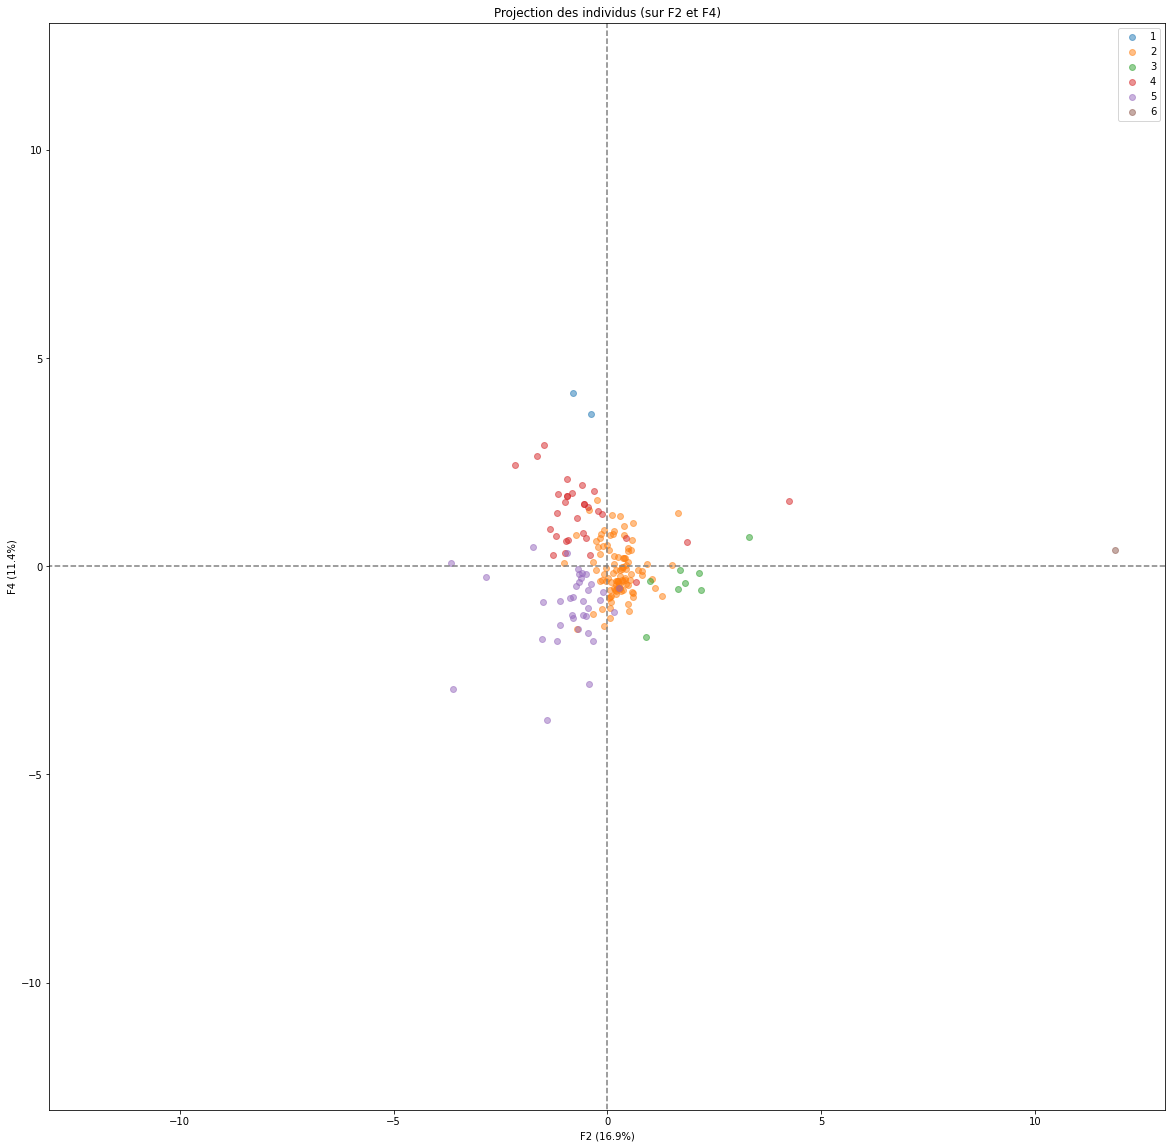

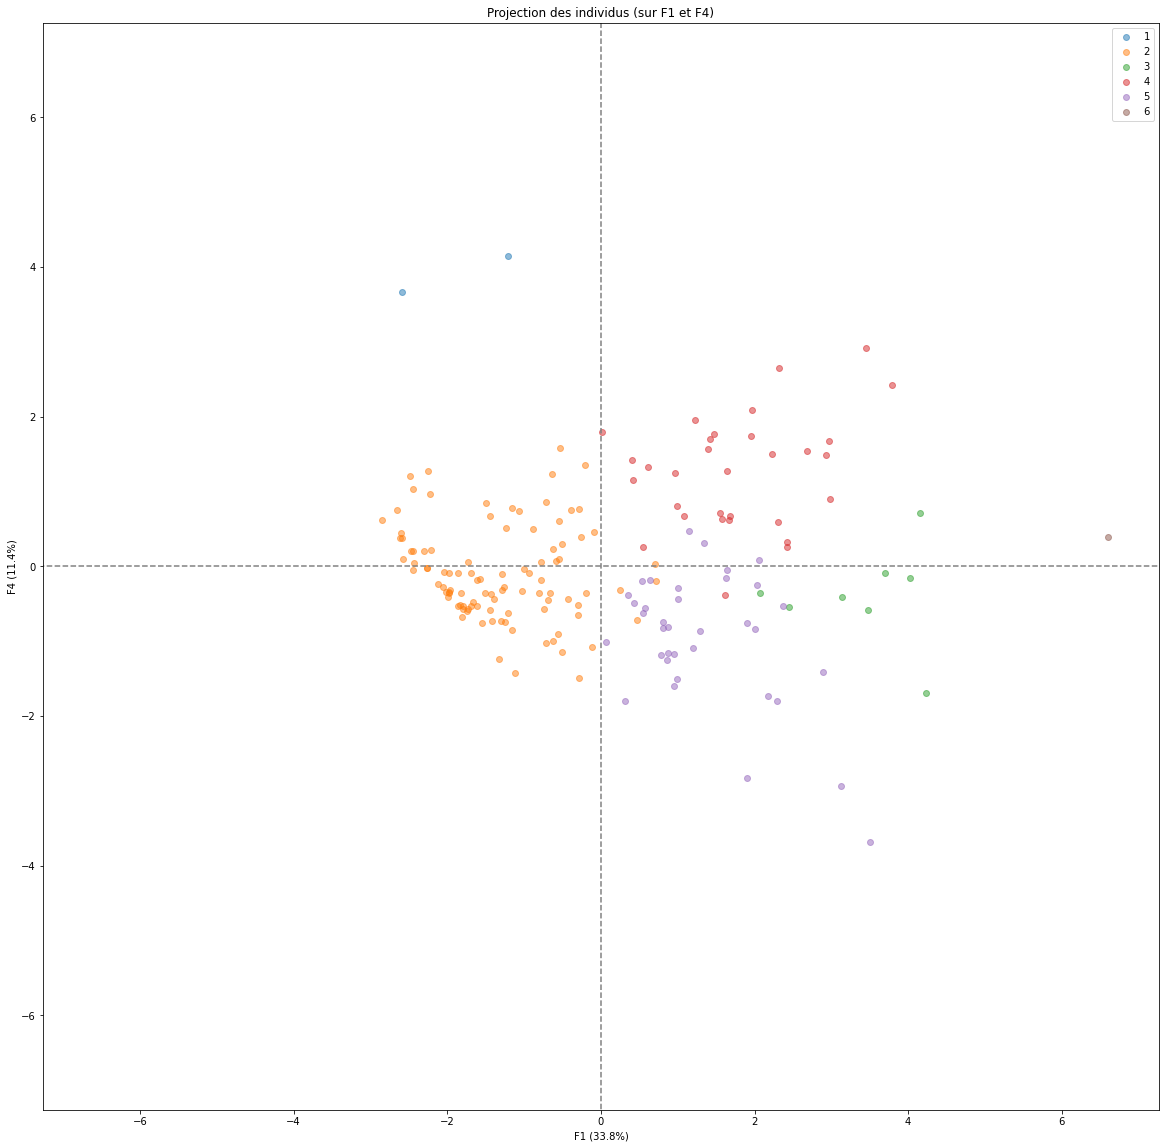

In [127]:
#Projection des individus, coloration par cluster (ici issus du Kmeans)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(1,3),(0,3)], 
                         illustrative_var = df_final["cluster kmeans new"], alpha = 0.5)

F1 : taille du marché

F2 : recul des parts sur le marché international

F3 : principaux acteurs de l'export de poulet (quantité et hausse des parts d'export)

F4 : insécurité alimentaire du pays ou pauvreté par habitant

Les projections cluster CAH et clusters Kmeans sont quasiment identiques, excepté pour le cluster 7 sur le premier plan factoriel

In [128]:
#Je crée une nouvelle table 'df_flt' où je ne garde que les données correspondant au cluster 5.
df_flt = df.loc[df['cluster CAH']==5]
df_flt.head()

,Food supply (kcal/capita/day) Poultry Meat 2019,Total Population - Both sexes Population 2019,Domestic supply quantity Poultry Meat 2019 per capita,Export Quantity Poultry Meat 2019 per capita,Import Quantity Poultry Meat 2019 per capita,Production Poultry Meat 2019 per capita,Import share evolution 17-2019,Export share evolution 17-2019,Gross domestic product per capita 2019,Political stability and absence of violence 2019,cluster CAH,cluster kmeans,cluster kmeans new
Area,,,,,,,,,,,,,
Austria,64.0,8955000.0,19.765494,9.715243,12.618649,14.740369,0.000094,0.002575,55833.3,0.98,5,2,5
Belarus,97.0,9452000.0,28.671181,18.726196,1.057977,49.407533,-0.000617,0.006608,19283.1,0.29,5,2,5
Belgium,44.0,11539000.0,16.205910,48.964382,27.732039,38.824855,0.000254,-0.009045,51742.7,0.48,5,2,5
Bulgaria,85.0,7000000.0,23.000000,6.142857,15.857143,15.571429,0.000365,0.000354,23191.6,0.54,5,2,5
Chile,150.0,18952000.0,35.880118,9.128324,7.228789,40.576192,-0.000436,0.005890,24967.6,0.21,5,0,4


In [129]:
df_flt.shape

(36, 13)

In [130]:
df_pca = df_flt.copy()

In [131]:
# suppression des colonnes non utiles
df_pca.drop(columns = ["cluster CAH", "cluster kmeans", "cluster kmeans new"], inplace=True)

### VI.Réalisation du clustering CAH et Kmeans pour le groupe N5
Calcul des coefficients de silhouette et DB scores pour le groupe N5

In [132]:
# préparation des données pour clustering et ACP
X = df_pca.values
names = df_pca.index
features = df_pca.columns

In [133]:
#centrage et réduction des valeurs
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [134]:
#générer la matrice des liens, utilisation de la méthode de Ward
Z = linkage(X_scaled, method='ward', metric='euclidean')

<Figure size 1080x1080 with 0 Axes>

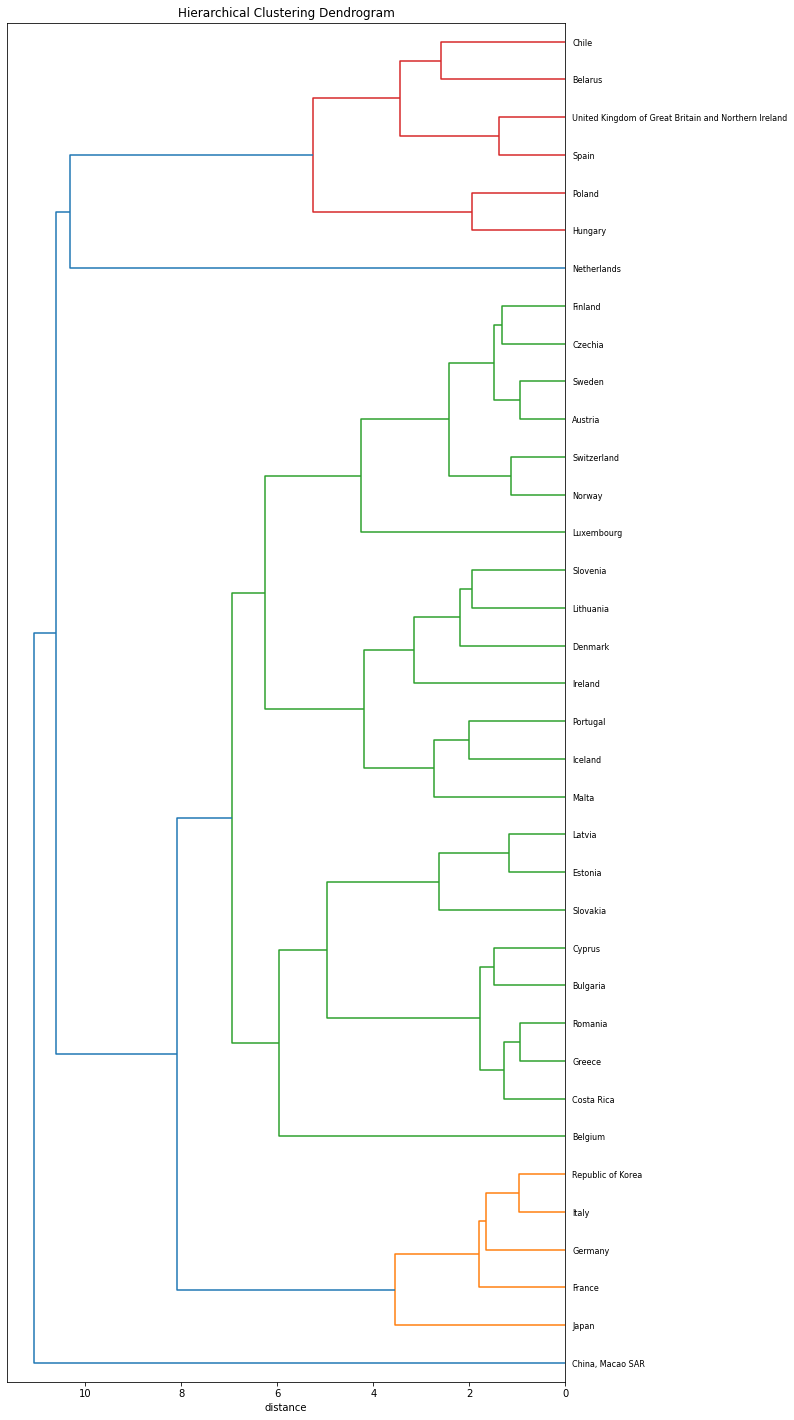

In [135]:
# affichage du dendrogramme
fig = plt.figure(figsize = (15,15))
plot_dendrogram(Z, names)

In [136]:
#calcul des indicateurs pour la méthode CAH
db_CAH, slc_CAH = {}, {}
for i in range (3,14) :
    clusters_CAH = fcluster(Z, i, criterion='maxclust')
    slc_CAH[i] = metrics.silhouette_score(X_scaled, clusters_CAH)
    db_CAH[i] = metrics.davies_bouldin_score(X_scaled, clusters_CAH)

In [137]:
#calcul des indicateurs pour la méthode Kmeans
inertia, db_km, slc_km = {}, {}, {}
for i in range (3,14) :
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    clusters_km = kmeans.labels_
    inertia[i] = kmeans.inertia_
    slc_km[i] = metrics.silhouette_score(X_scaled, clusters_km)
    db_km[i] = metrics.davies_bouldin_score(X_scaled, clusters_km)

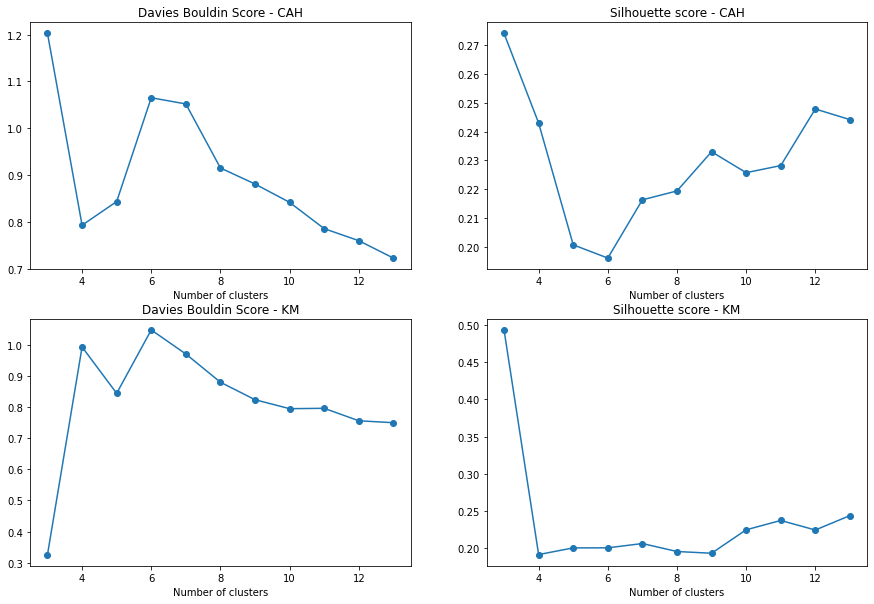

In [138]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(db_CAH.keys(), list(db_CAH.values()), marker='o')
ax1.set_title("Davies Bouldin Score - CAH")
ax1.set_xlabel("Number of clusters")
ax2.plot(slc_CAH.keys(), list(slc_CAH.values()), marker='o' )
ax2.set_title("Silhouette score - CAH")
ax2.set_xlabel("Number of clusters")
ax3.plot(db_km.keys(), list(db_km.values()), marker='o')
ax3.set_title("Davies Bouldin Score - KM")
ax3.set_xlabel("Number of clusters")
ax4.plot(slc_km.keys(), list(slc_km.values()), marker='o')
ax4.set_title("Silhouette score - KM")
ax4.set_xlabel("Number of clusters")
plt.show()

Les indicateurs CAH donnent de meilleurs scores pour un nombre de cluster égale à 3

Les ndicateurs KM donnent de meilleurs scores pour un nombre de cluster égale à 3

On fixe le nombre de clusters à 3

### Clustering CAH

### 1 Clustering CAH pour le groupe de cluster 3

In [139]:
#définition des clusters par la méthode CAH
clusters_CAH = fcluster(Z, 3, criterion='maxclust')

In [140]:
#les numéro de cluster sont ajoutés au df
df_pca["cluster CAH"] = clusters_CAH

### Clustering Kmeans

In [141]:
#définition des clusters par la méthode Kmeans
#nombre de clusters souhaités
n_clust = 3

# clustering par K-means, ici pour récupérer les coordonnées des centroides calculés, 
#pour initialisation du kmeans avec init dans un second temps
km_get_centroïdes = KMeans(n_clusters=n_clust, random_state=0)
km_get_centroïdes.fit(X_scaled)

# récupération des coordonnées des centroïdes pour utilisation dans init
centroids_after_kmeans_get_centroides = km_get_centroïdes.cluster_centers_

In [142]:
centroids_after_kmeans_get_centroides


array([[ 0.01542294,  0.02394878,  0.03315243, -0.11284174, -0.17028831,
        -0.02527768, -0.12339366, -0.0760554 , -0.11535112, -0.04833103],
       [-2.58414407, -0.1169458 , -2.65889418,  4.49958386,  2.17976797,
         2.33947205, -0.53839078,  3.06377967,  0.40662961,  0.26809345],
       [ 2.05976418, -0.69731261,  1.53171154, -0.66296465,  3.6100344 ,
        -1.48003083,  4.73377521, -0.47789593,  3.5153084 ,  1.3751617 ]])

In [143]:
#création d'un np array avec les coordonnées des centroïdes
centroids_after_kmeans_get_centroides = np.array([[ 0.01542294,  0.02394878,  0.03315243, -0.11284174, -0.17028831,
        -0.02527768, -0.12339366, -0.0760554 , -0.11535112, -0.04833103],
       [-2.58414407, -0.1169458 , -2.65889418,  4.49958386,  2.17976797,
         2.33947205, -0.53839078,  3.06377967,  0.40662961,  0.26809345],
       [ 2.05976418, -0.69731261,  1.53171154, -0.66296465,  3.6100344 ,
        -1.48003083,  4.73377521, -0.47789593,  3.5153084 ,  1.3751617 ]])


In [144]:
# clustering par K-means avec initialisation des centroïdes aux coordonnées précedemment calculées
km = KMeans(n_clusters=n_clust, init = centroids_after_kmeans_get_centroides, max_iter= 500)
km.fit(X_scaled)

# récupération des clusters attribués à chaque individu et des coordonnées des centroïdes
clusters_km = km.labels_
centroids_after_kmeans = km.cluster_centers_

/Users/fabienmirosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [145]:
#les numéro de cluster sont ajoutés au df
df_pca["cluster kmeans"] = clusters_km


### Etude de la concordance entre les clusters issus de la CAH et du Kmeans

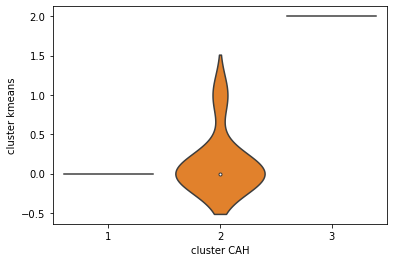

In [146]:
# recherche de la concordance des libellés des clusters CAH vs kmeans
sns.violinplot(x="cluster CAH", y="cluster kmeans", data=df_pca[["cluster CAH","cluster kmeans"]])
plt.show()

In [147]:
# on attribue les mêmes numéros de cluster CAH et Kmeans
for element in zip([0,1,2], [1,2,3]) :
    df_pca.loc[df_pca['cluster kmeans'] == element[0], 'cluster kmeans new'] = element[1]

In [148]:
#conversion des données kmeans new en entier
df_pca["cluster kmeans new"] = df_pca["cluster kmeans new"].astype(int)

### Liste des pays par cluster

In [149]:
for value in [1,2,3] :
    print(f'Liste des pays cluster {value} par méthode CAH : ')
    print(df_pca[df_pca["cluster CAH"] == value].index)
    print(f'Liste des pays cluster {value} par méthode Kmeans : ')
    print(df_pca[df_pca["cluster kmeans new"] == value].index)
    print(" ")

Liste des pays cluster 1 par méthode CAH : 
Index(['Austria', 'Belgium', 'Bulgaria', 'Costa Rica', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'Ireland', 'Italy', 'Japan', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malta', 'Norway', 'Portugal', 'Republic of Korea',
       'Romania', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland'],
      dtype='object', name='Area')
Liste des pays cluster 1 par méthode Kmeans : 
Index(['Austria', 'Belarus', 'Belgium', 'Bulgaria', 'Chile', 'Costa Rica',
       'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France',
       'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Japan',
       'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Norway', 'Poland',
       'Portugal', 'Republic of Korea', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland',
       'United Kingdom of Great Britain and Northern Ireland'],
      dtype='object', name='Area')
 
L

### Heatmap croisement clusters et variables

In [150]:
#calcul de la moyenne par cluster CAH et variable
means_cluster_CAH = df_pca.pivot_table(index = "cluster CAH", aggfunc='mean' ).drop(columns = ["cluster kmeans", "cluster kmeans new"])

In [151]:
#standardisation des valeurs
means_cluster_CAH_scaled = preprocessing.StandardScaler().fit_transform(means_cluster_CAH)

In [152]:
#générer le dataframe avec les valeurs standardisées
means_cluster_CAH_scaled = pd.DataFrame(means_cluster_CAH_scaled, index = [1,2,3], columns= means_cluster_CAH.columns)

In [153]:
#calcul de la moyenne par cluster Kmeans et variable
means_cluster_kmeans = df_pca.pivot_table(index = "cluster kmeans new", aggfunc='mean' ).drop(columns = ["cluster kmeans", "cluster CAH"])

In [154]:
#standardisation des valeurs
means_cluster_kmeans_scaled = preprocessing.StandardScaler().fit_transform(means_cluster_kmeans)

In [155]:
#générer le dataframe avec les valeurs standardisées
means_cluster_kmeans_scaled = pd.DataFrame(means_cluster_kmeans_scaled, index = [1,2,3], columns= means_cluster_kmeans.columns)

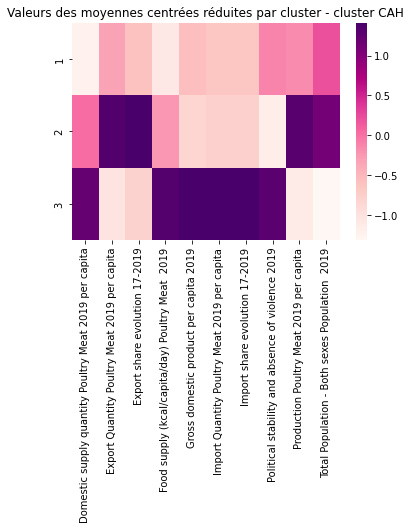

In [156]:
MCR_clusters_CAH = plt.figure()
cmap = sns.cm.rocket_r
sns.heatmap(means_cluster_CAH_scaled, cmap ='RdPu')
plt.title("Valeurs des moyennes centrées réduites par cluster - cluster CAH")
plt.show()

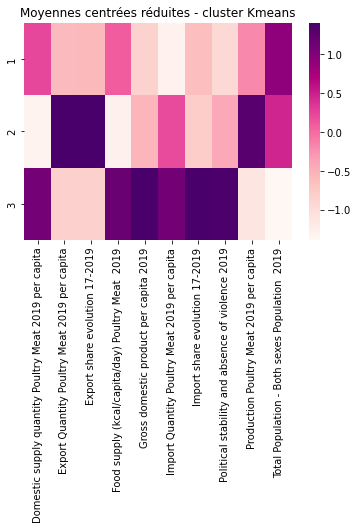

In [157]:
# générer un masque pour la matrice des corrélations
MCR_clusters_kmeans = plt.figure()
cmap = sns.cm.rocket_r
sns.heatmap(means_cluster_kmeans_scaled, cmap ='RdPu')
plt.title("Moyennes centrées réduites - cluster Kmeans")
plt.show()

In [158]:
# compte tenu du faible nombre de variables, on fixe le nombre de composantes à 6
n_comp = 4

In [159]:
#initialisation d'un objet de type PCA
pca = decomposition.PCA(n_components=n_comp)

In [160]:
pca.fit(X_scaled)

PCA(n_components=4)

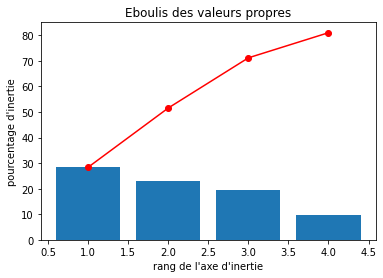

In [161]:
#affichage du graph des éboulis des valeurs propres ( = intertie de chaque composante)
display_scree_plot(pca)

### Cercle des corrélations

In [162]:
#récupération des composantes de l'objet pca
pcs = pca.components_

In [163]:
axis_ranks = [(0,1),(2,3)]
#définition des différents plans factoriels que nous souhaitons utiliser, ici 4, qui permettent d'expliquer 80% de l'inertie

In [164]:
#association des numéro aux libellés des variables
features_n = [value for value in range(1,(len(features)+1))]

In [165]:
df_pca.columns


Index(['Food supply (kcal/capita/day) Poultry Meat  2019',
       'Total Population - Both sexes Population  2019',
       'Domestic supply quantity Poultry Meat 2019 per capita',
       'Export Quantity Poultry Meat 2019 per capita',
       'Import Quantity Poultry Meat 2019 per capita',
       'Production Poultry Meat 2019 per capita',
       'Import share evolution 17-2019', 'Export share evolution 17-2019',
       'Gross domestic product per capita 2019',
       'Political stability and absence of violence 2019', 'cluster CAH',
       'cluster kmeans', 'cluster kmeans new'],
      dtype='object')

In [166]:
#légende du cercle des corrélations
for element in zip(features_n, features) :
    print (element)

(1, 'Food supply (kcal/capita/day) Poultry Meat  2019')
(2, 'Total Population - Both sexes Population  2019')
(3, 'Domestic supply quantity Poultry Meat 2019 per capita')
(4, 'Export Quantity Poultry Meat 2019 per capita')
(5, 'Import Quantity Poultry Meat 2019 per capita')
(6, 'Production Poultry Meat 2019 per capita')
(7, 'Import share evolution 17-2019')
(8, 'Export share evolution 17-2019')
(9, 'Gross domestic product per capita 2019')
(10, 'Political stability and absence of violence 2019')


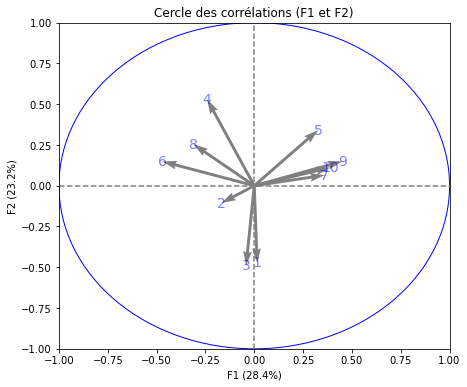

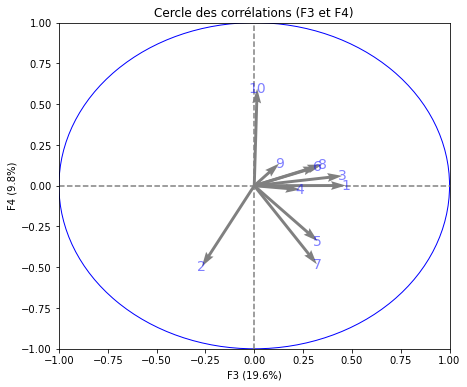

In [167]:
#cercle des corrélations
display_circles(pcs,n_comp,pca, axis_ranks, labels = features_n )

In [168]:
# calcul des coordonnées des individus
X_projected = pca.transform(X_scaled)

In [169]:
X_projected_df = pd.DataFrame(X_projected)


In [170]:
X_projected_df["cluster CAH"] = df_pca["cluster CAH"].values


In [171]:
X_projected_df = X_projected_df.groupby(by = "cluster CAH").mean()

In [172]:
centers_CAH_clusters = X_projected_df.values

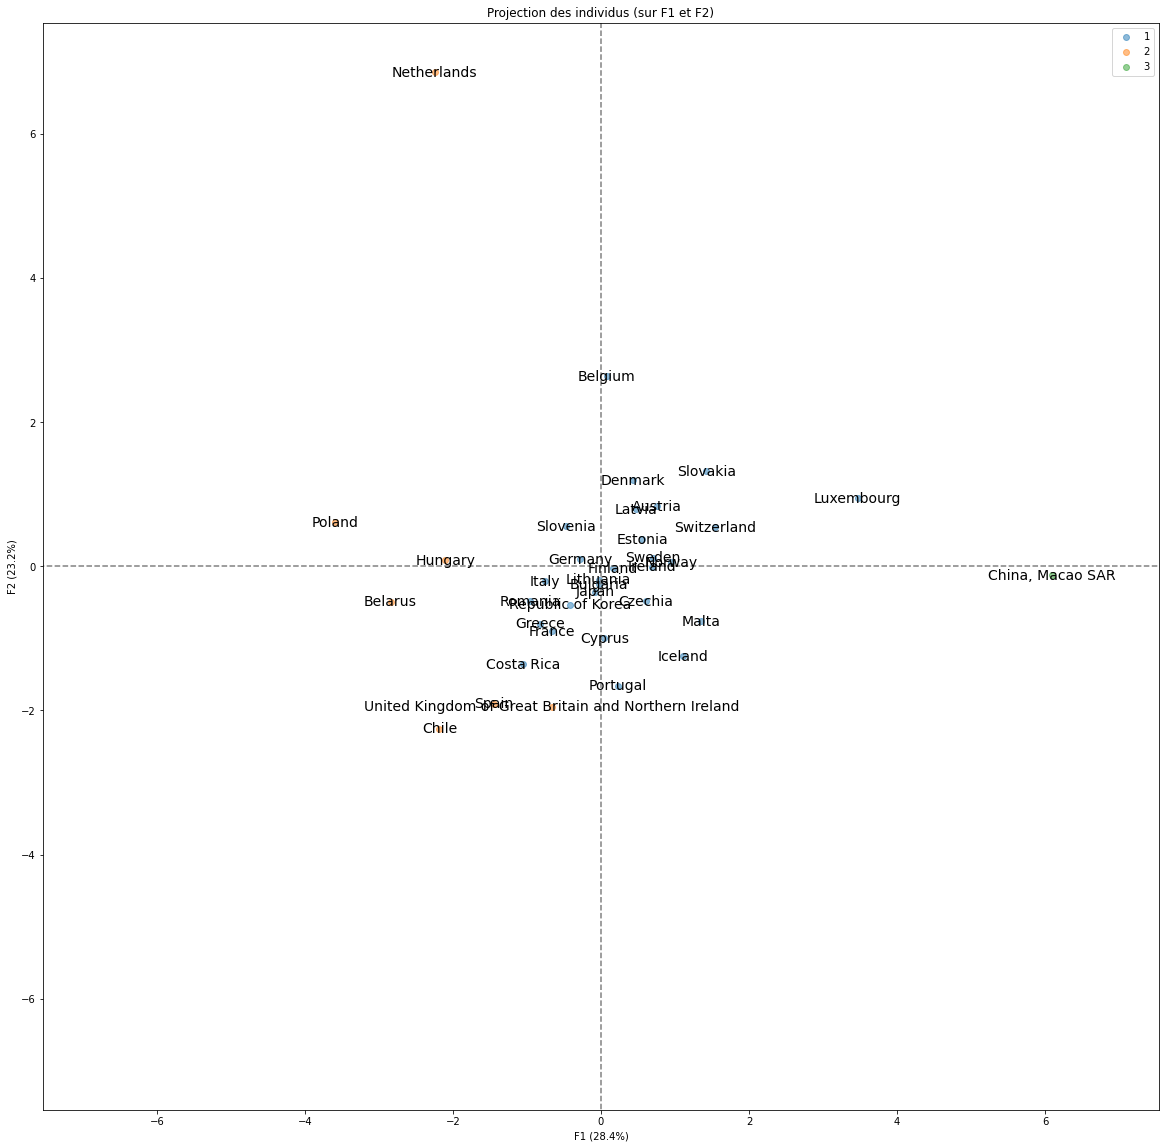

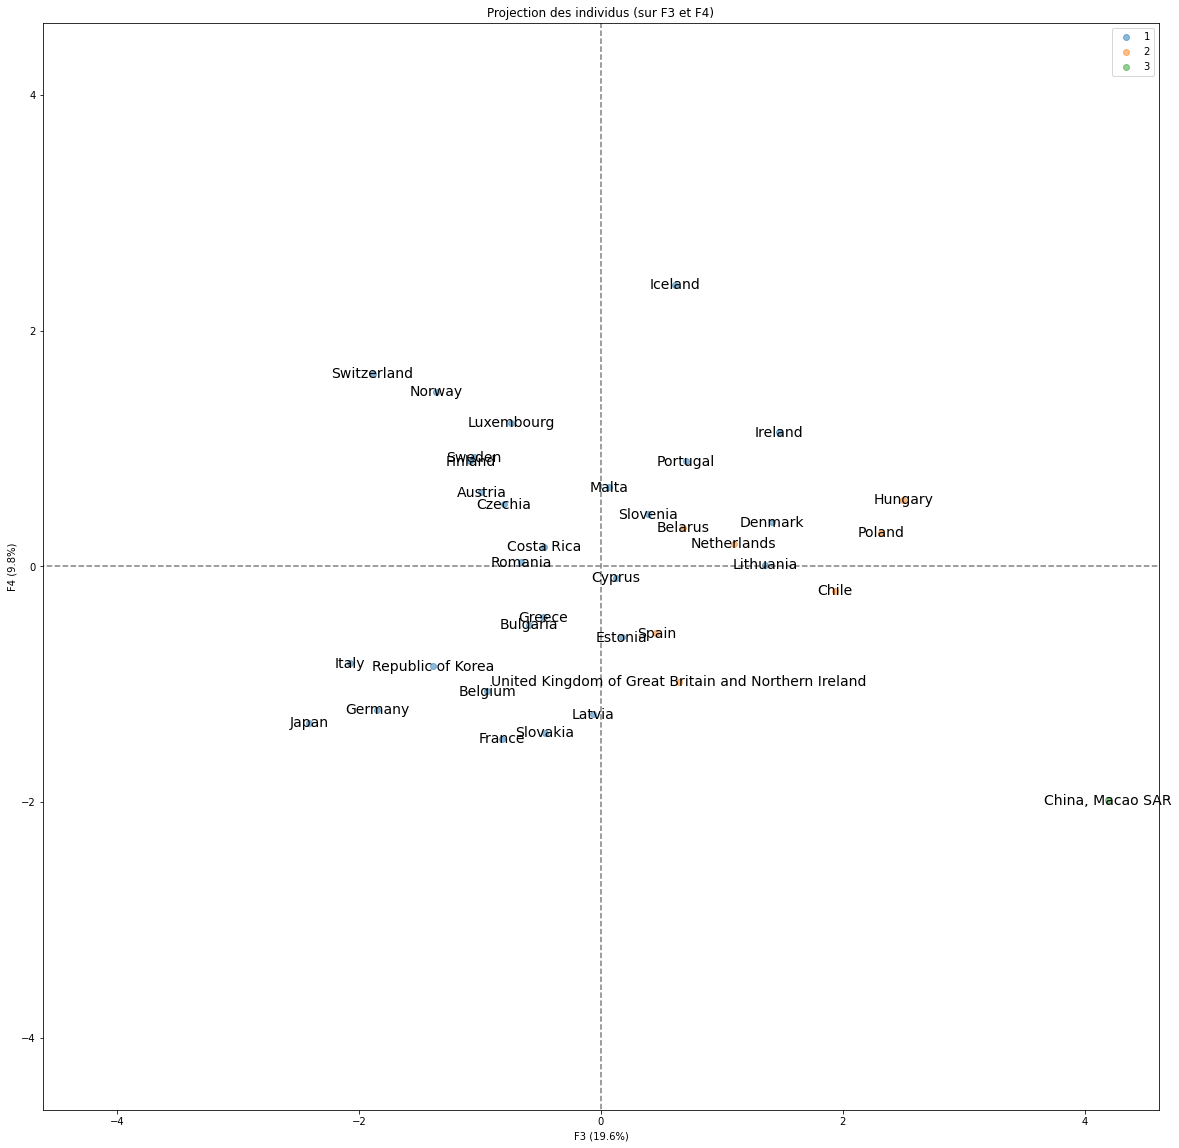

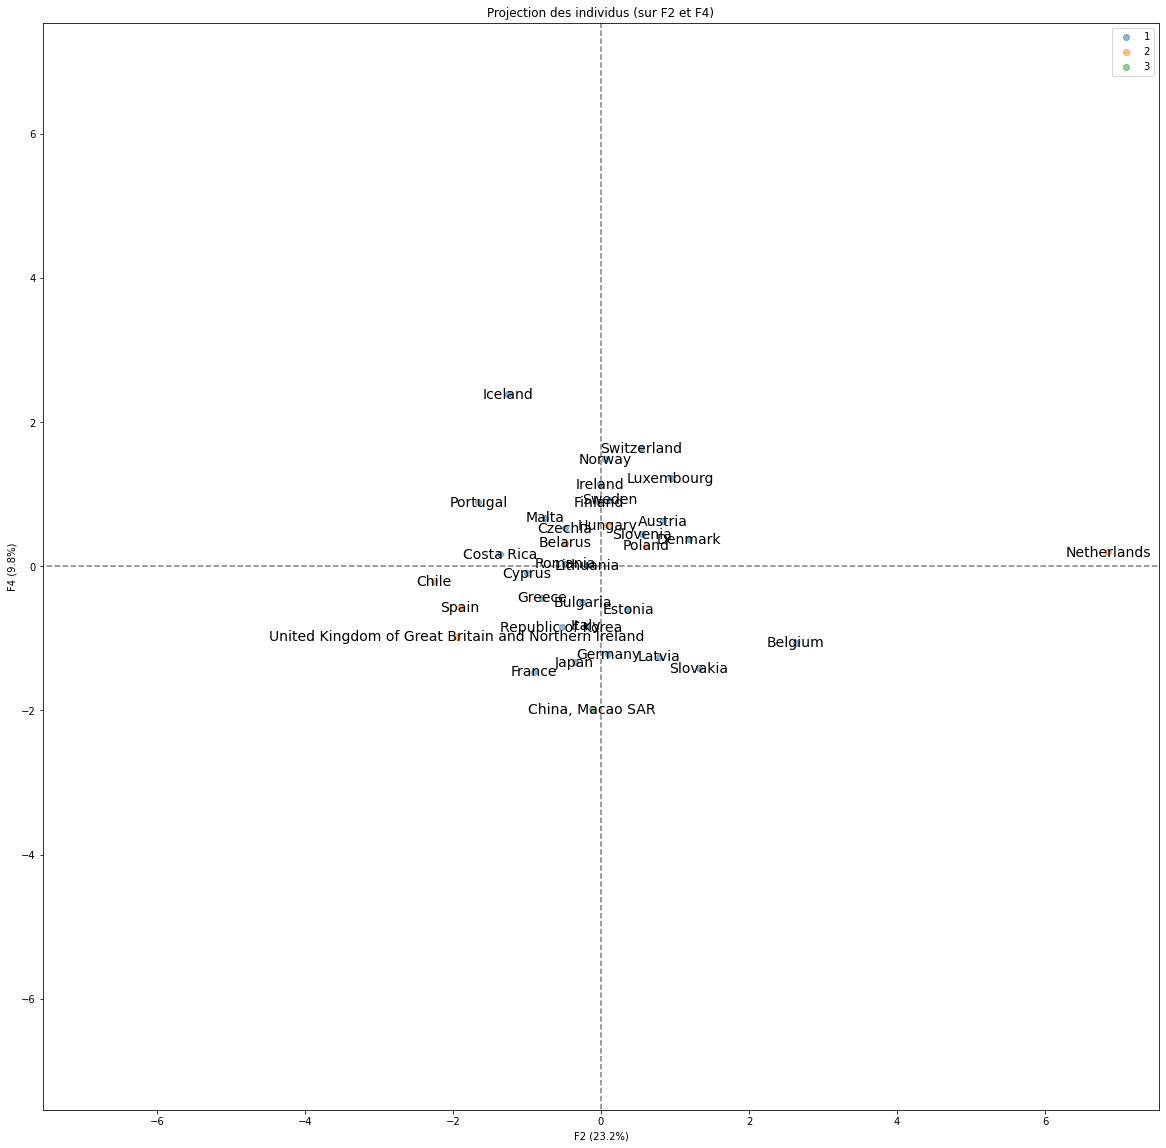

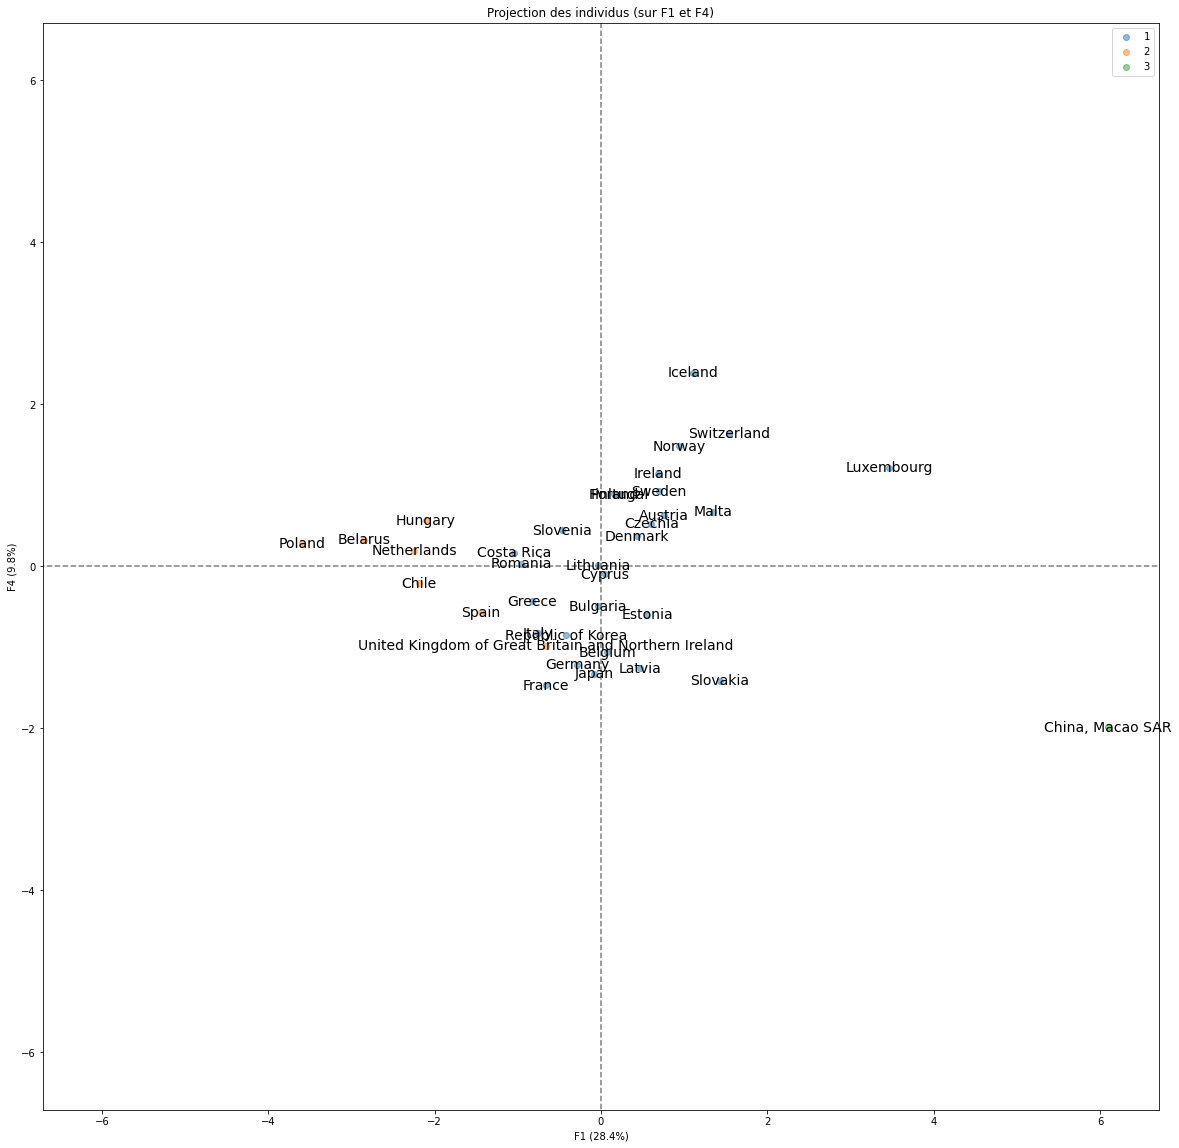

In [173]:
#Projection des individus , coloration par cluster (ici issus du CAH)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(1,3),(0,3)], illustrative_var = df_pca["cluster CAH"], alpha = 0.5, labels = np.array(names))


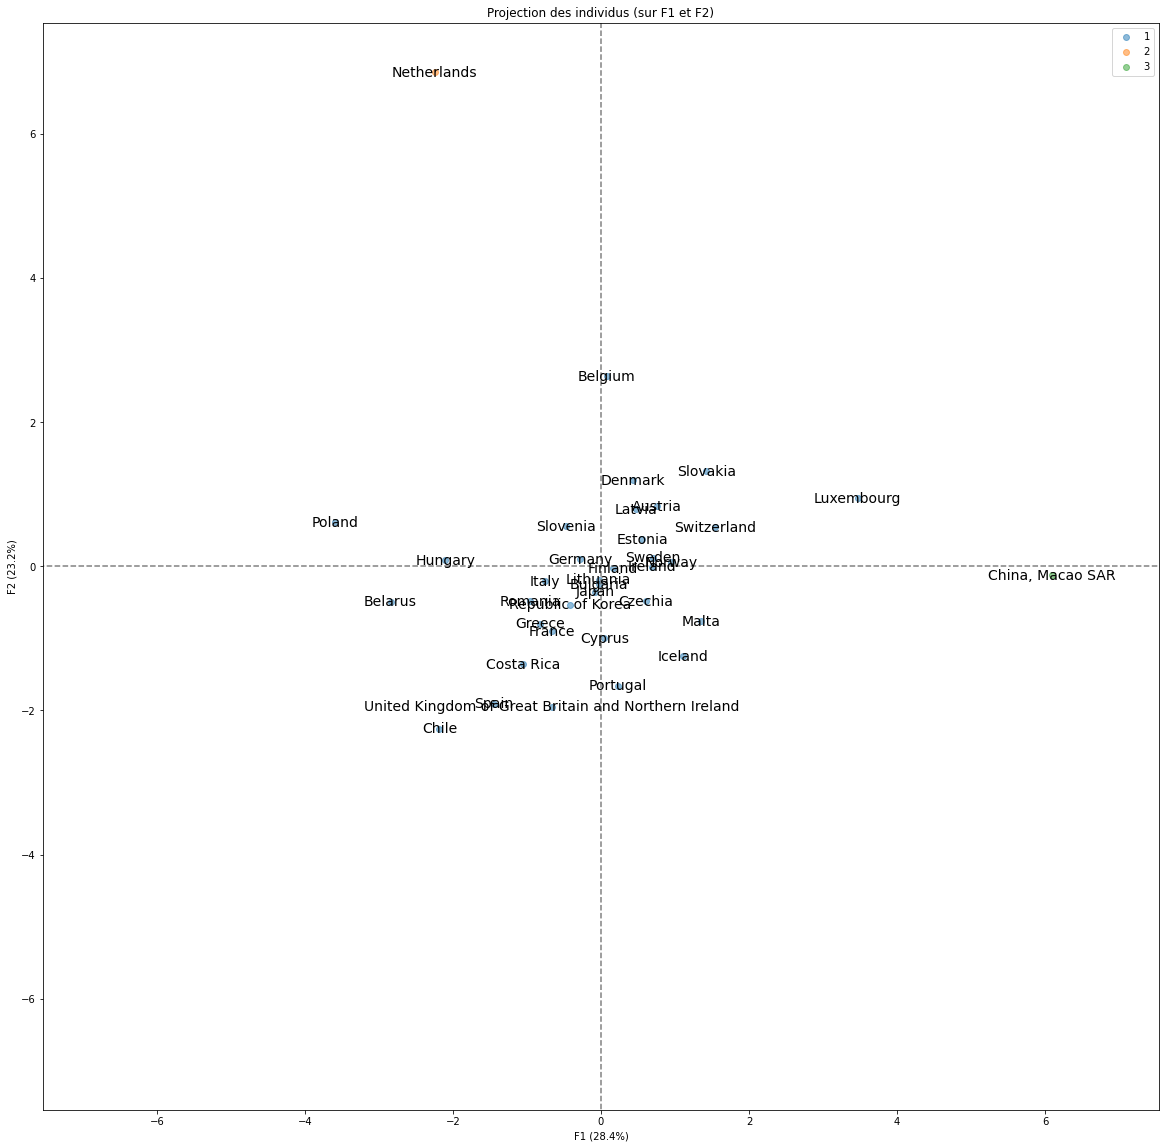

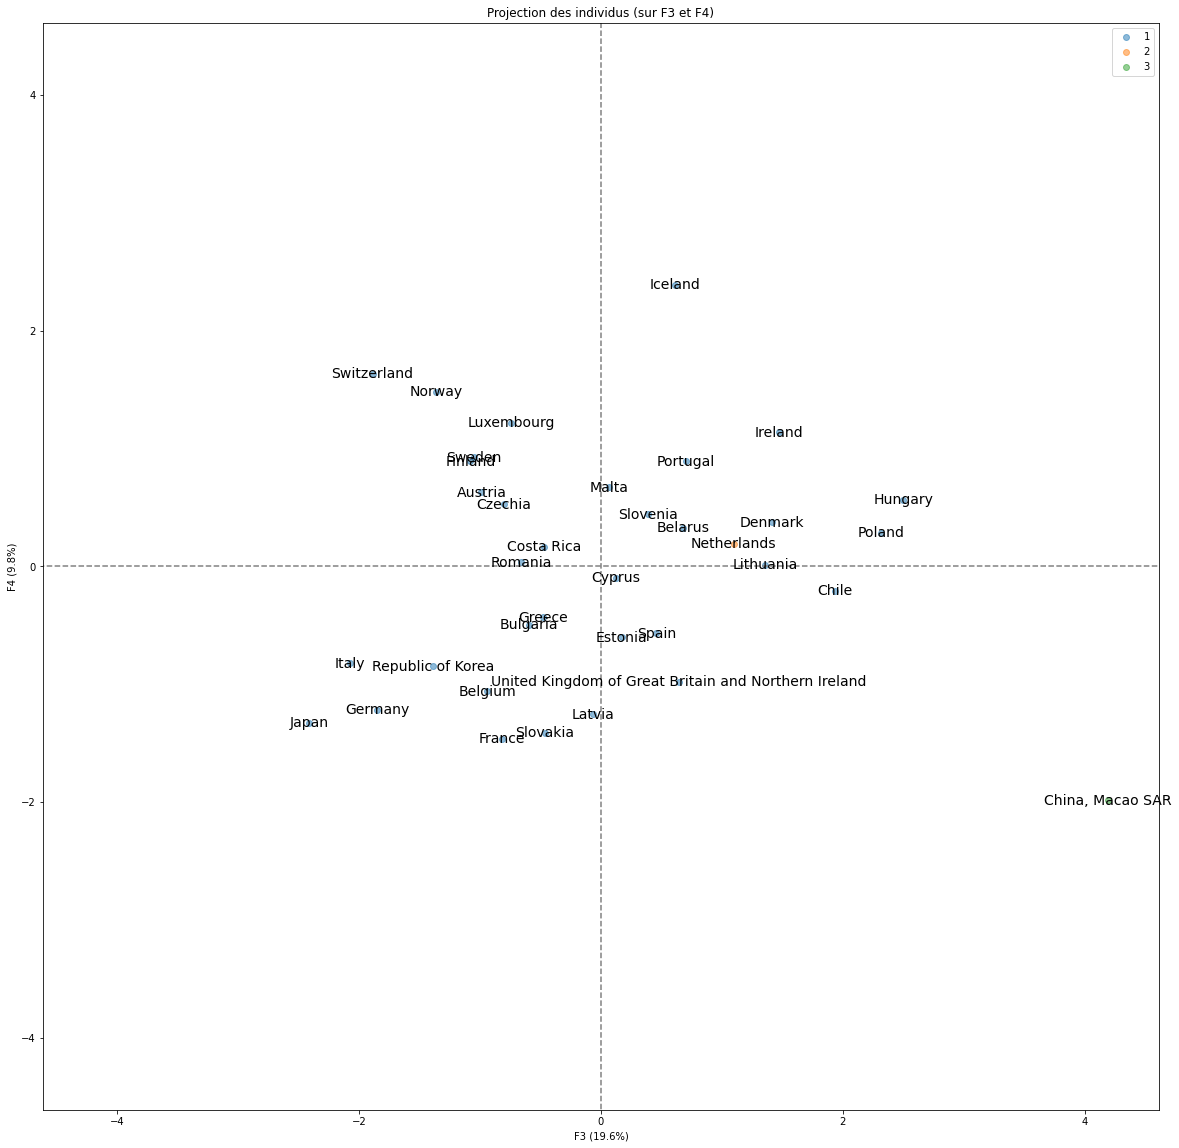

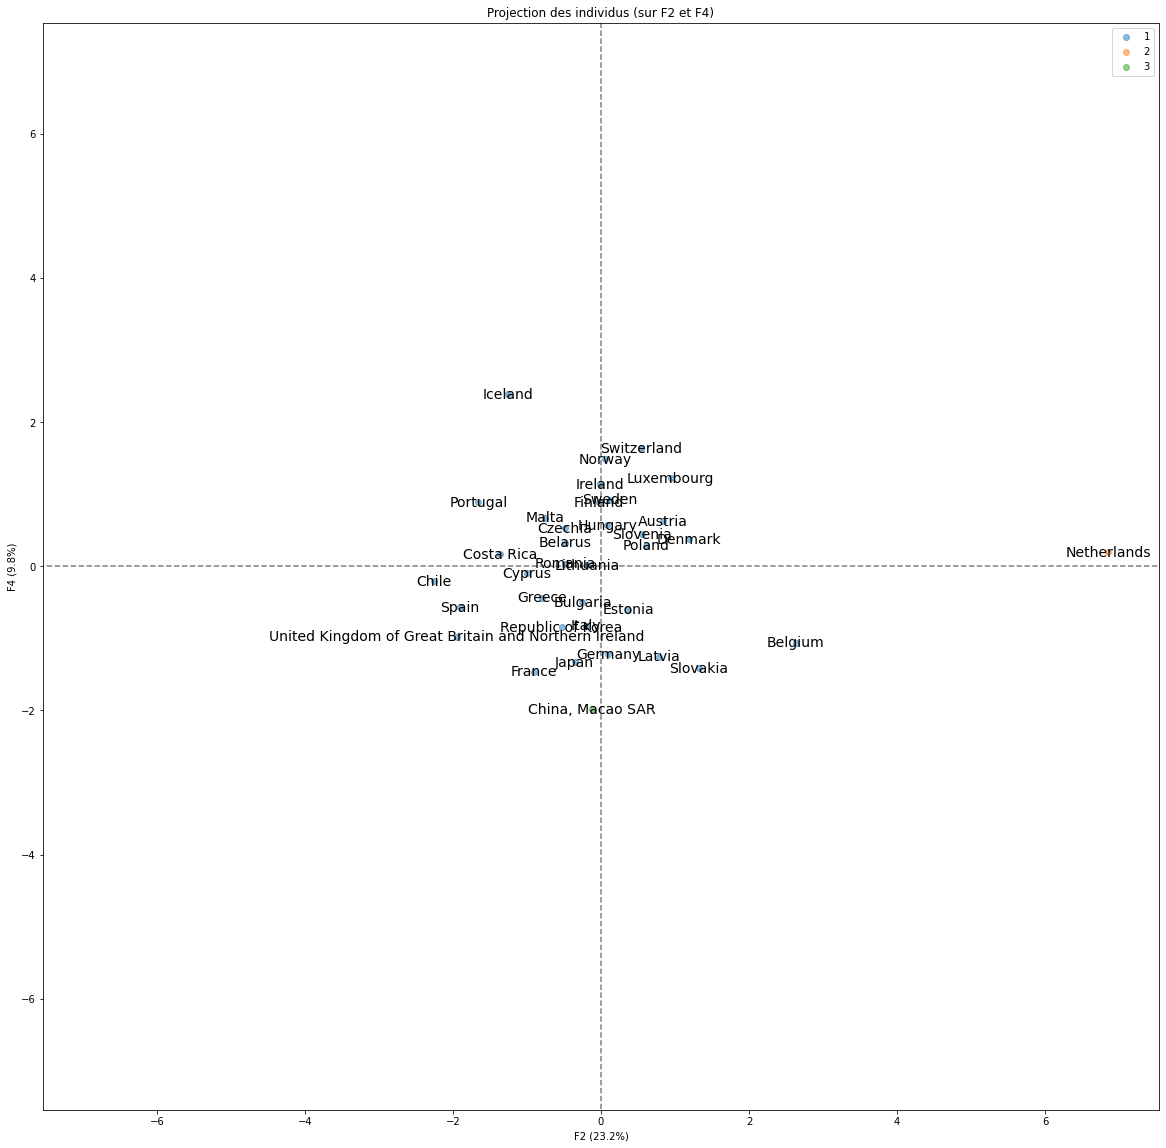

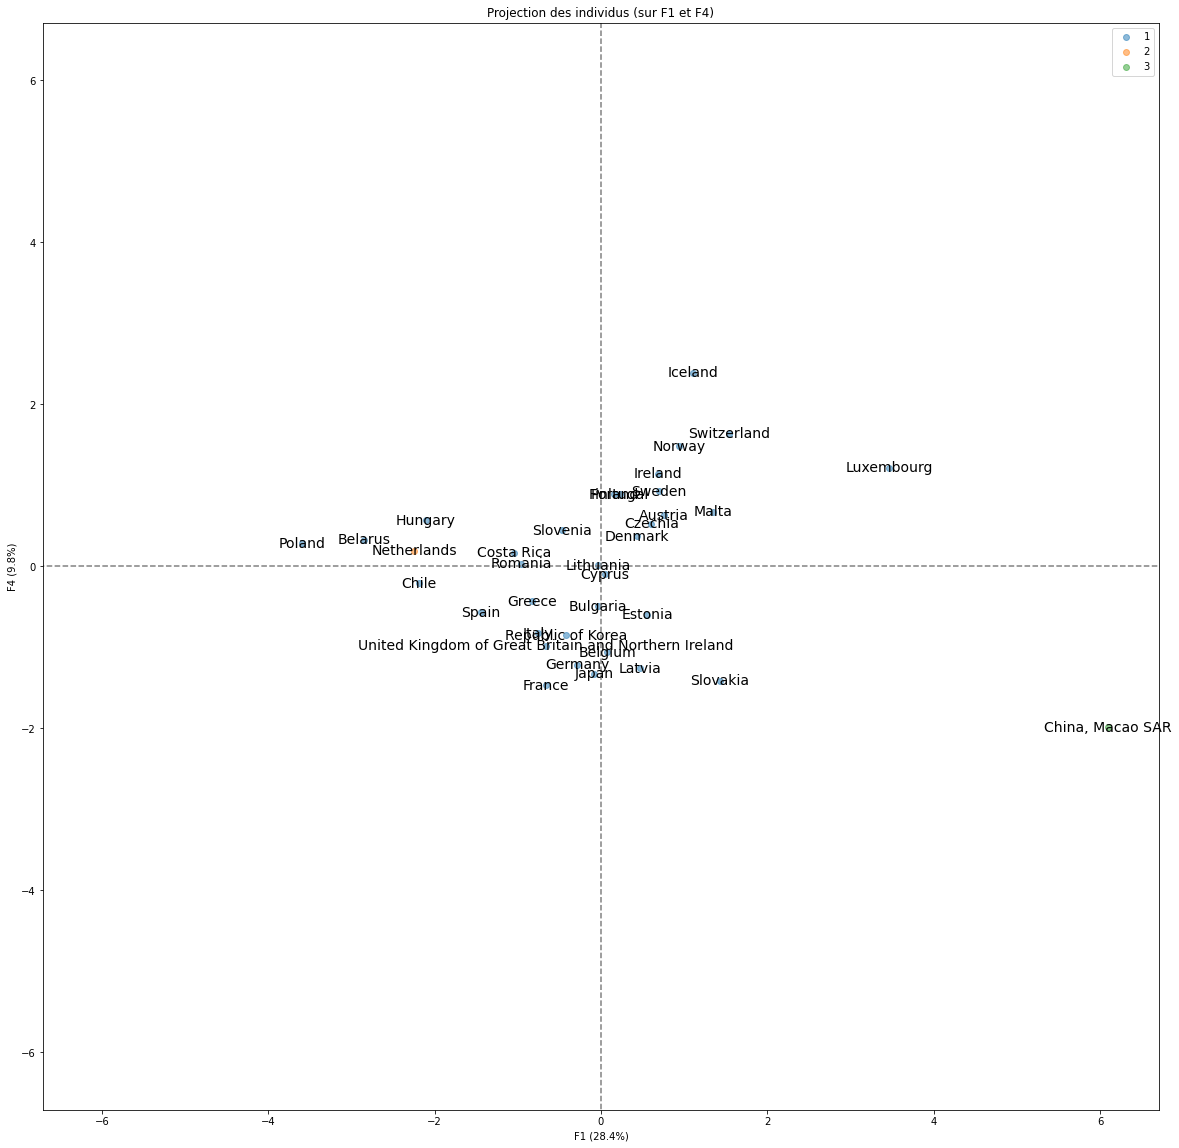

In [174]:
#Projection des individus, coloration par cluster (ici issus du Kmeans)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(1,3),(0,3)], illustrative_var = df_pca["cluster kmeans new"], alpha = 0.5, labels = np.array(names))

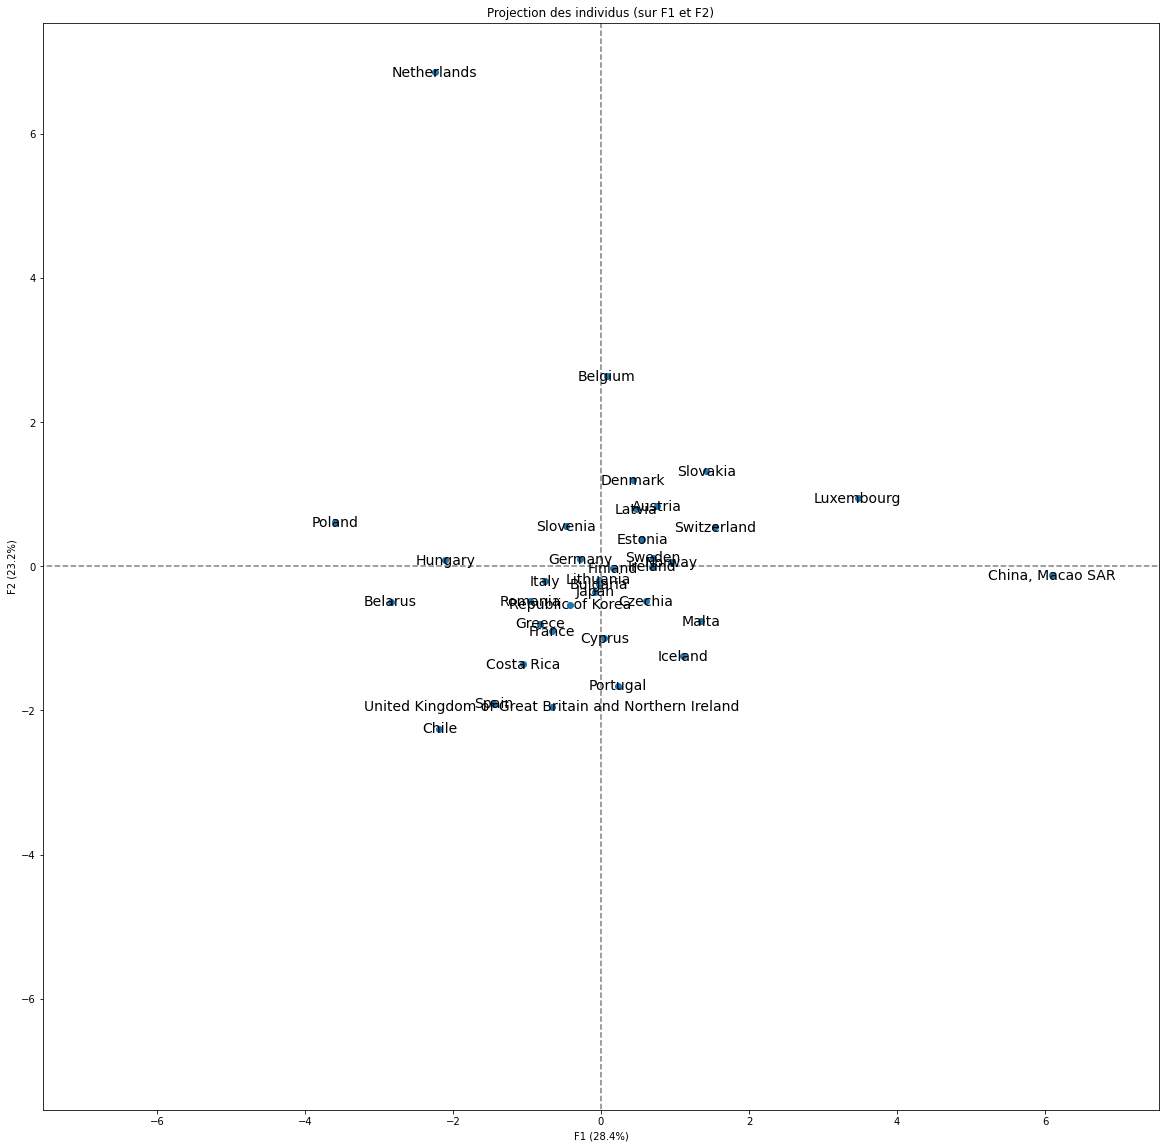

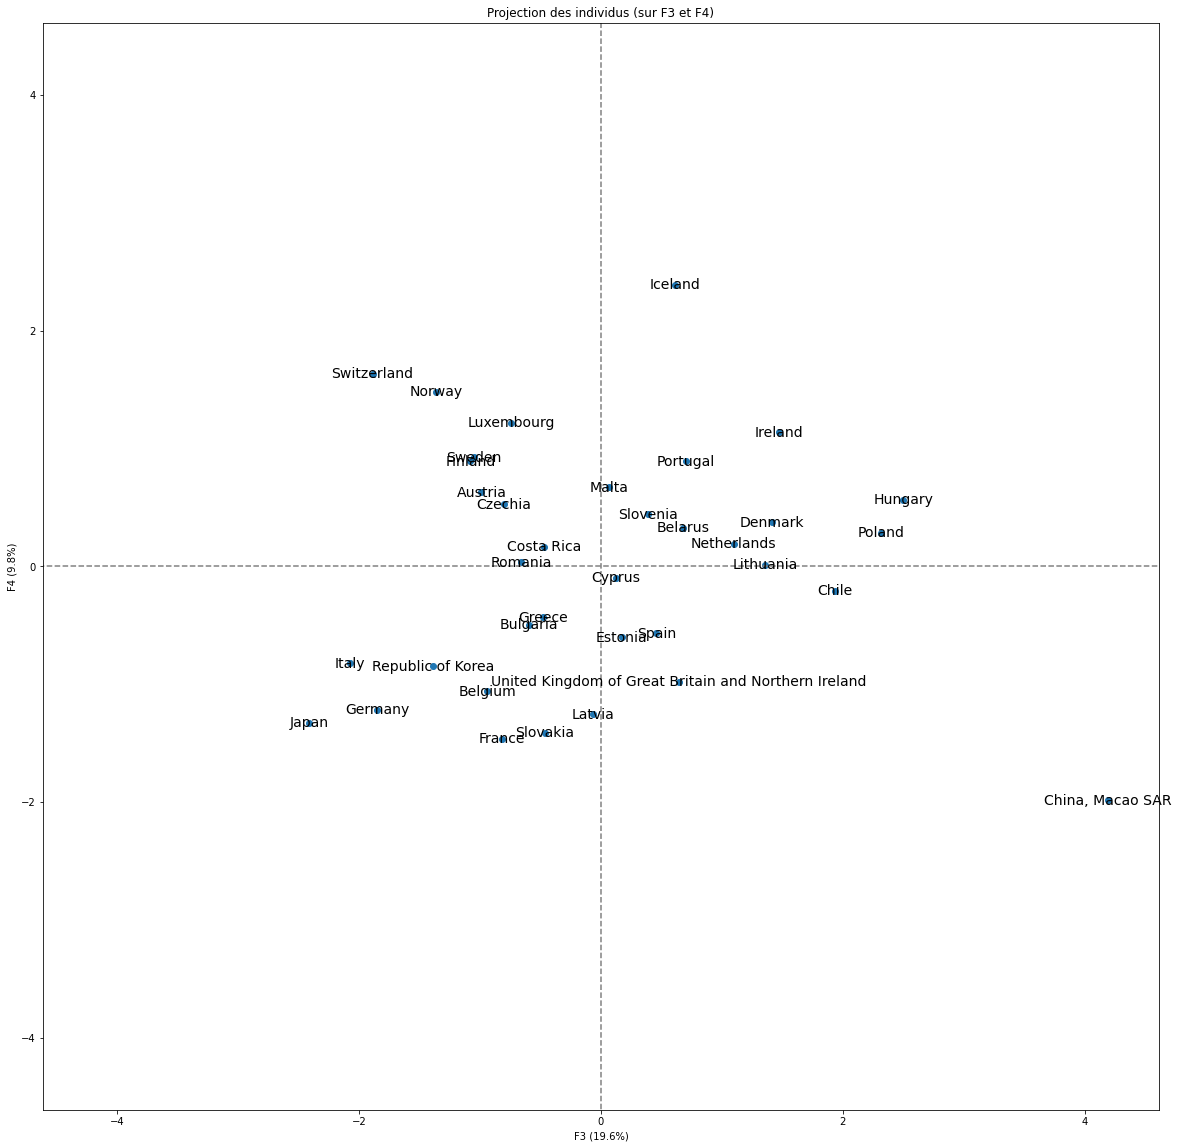

In [175]:
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3)], labels = np.array(names))

plt.show()

In [176]:
df_pca.shape

(36, 13)

### Je transforme le tout par population totale et plus par habitant

In [177]:
df_pca["Domestic supply quantity Poultry Meat 2019 per capita"] = ((df_pca["Domestic supply quantity Poultry Meat 2019 per capita"]* df_pca['Total Population - Both sexes Population  2019']))

df_pca["Export Quantity Poultry Meat 2019 per capita"] = ((df_pca["Export Quantity Poultry Meat 2019 per capita"]* df_pca['Total Population - Both sexes Population  2019']))

df_pca["Import Quantity Poultry Meat 2019 per capita"] = ((df_pca["Import Quantity Poultry Meat 2019 per capita"]* df_pca['Total Population - Both sexes Population  2019']))

df_pca["Production Poultry Meat 2019 per capita"] = ((df_pca["Production Poultry Meat 2019 per capita"]* df_pca['Total Population - Both sexes Population  2019']))

df_pca["Political stability and absence of violence 2019"] = df_pca["Political stability and absence of violence 2019"]

In [178]:
#changement de noms des colonnes recalculer :
df_pca.columns = ['Food supply (kcal/capita/day) Poultry Meat  2019',
       'Total Population - Both sexes Population  2019',
       'Domestic supply quantity Poultry Meat 2019',
       'Export Quantity Poultry Meat 2019',
       'Import Quantity Poultry Meat 2019',
       'Production Poultry Meat 2019',
       'Import share evolution 17-2019', 'Export share evolution 17-2019',
       'Gross domestic product per capita 2019',
       'Political stability and absence of violence 2019', 'cluster CAH',
       'cluster kmeans', 'cluster kmeans new']

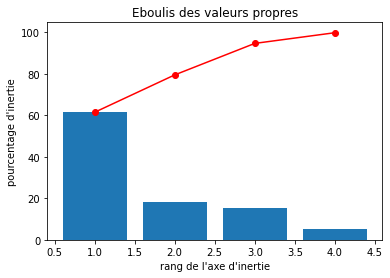

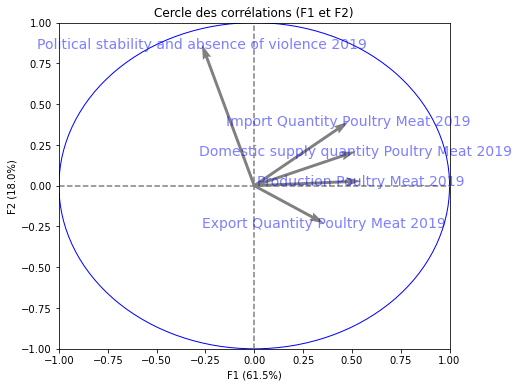

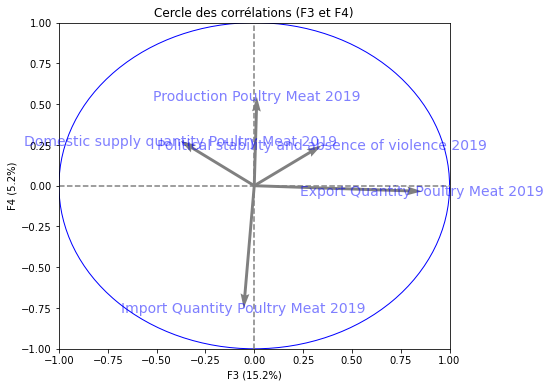

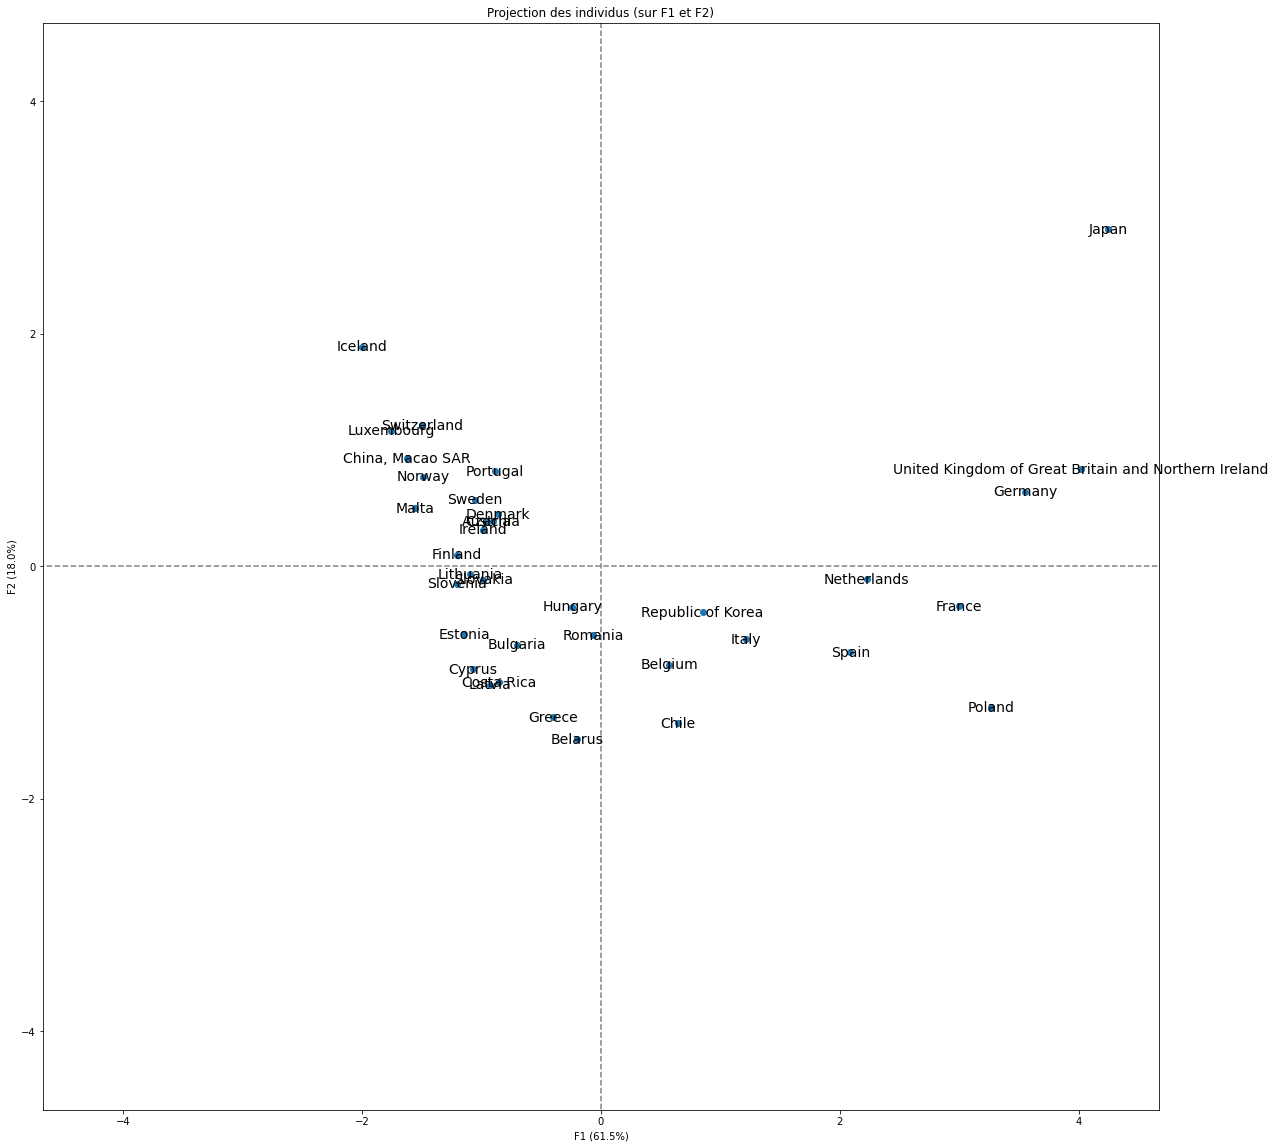

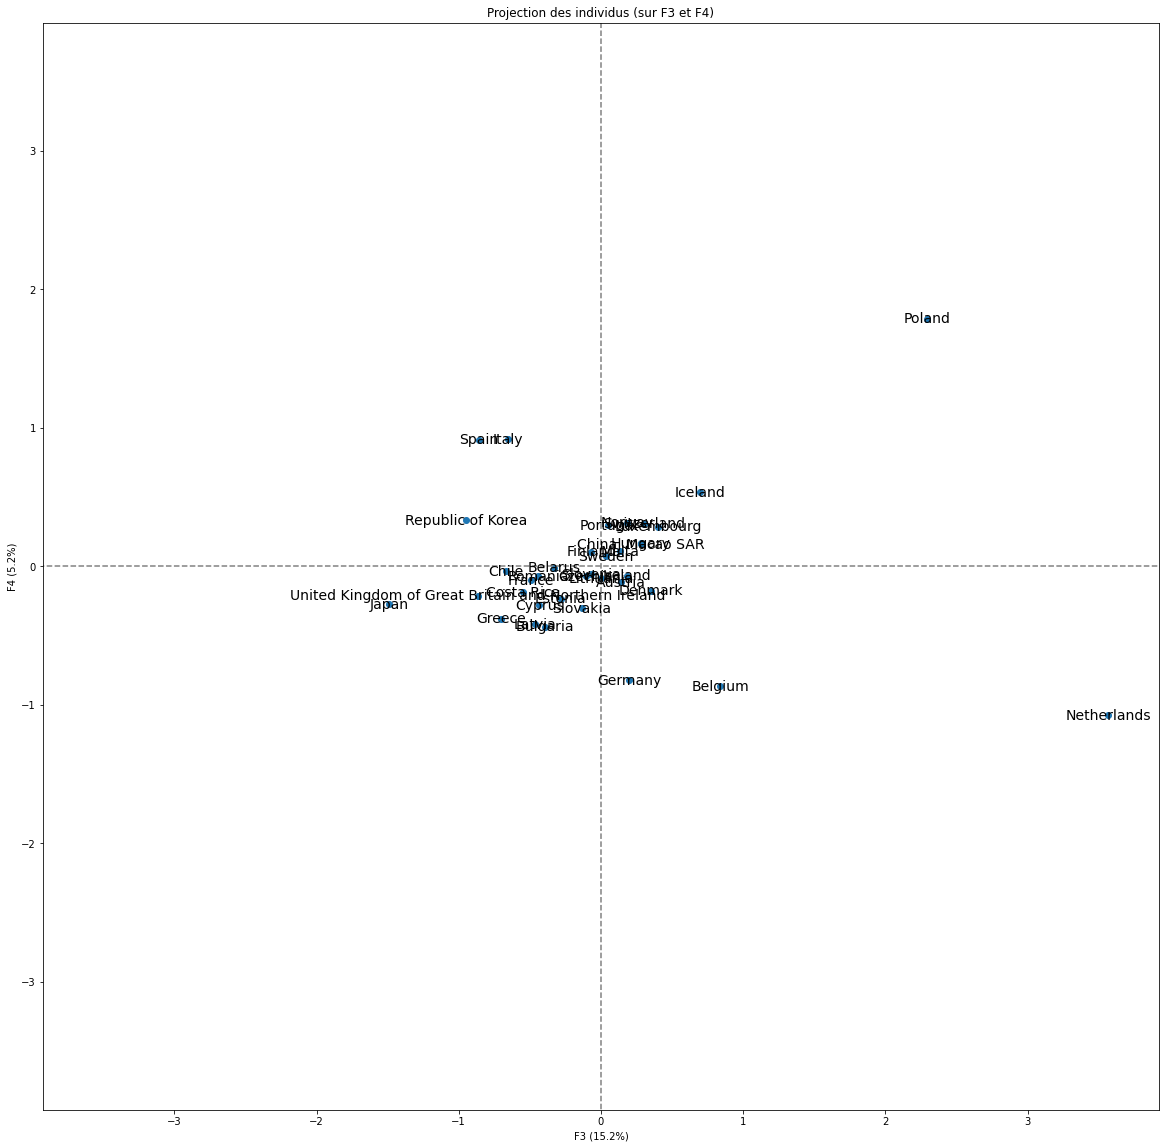

In [179]:
# choix du nombre de composantes à calculer
n_comp = 4


# selection des colonnes à prendre en compte dans l'ACP
data_pca = df_pca[["Domestic supply quantity Poultry Meat 2019",
               "Export Quantity Poultry Meat 2019",
               "Import Quantity Poultry Meat 2019",
               "Production Poultry Meat 2019",
               "Political stability and absence of violence 2019",
               ]]

X = data_pca.values
names = data_pca.index 
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(names))

plt.show()